In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from util import RuleClassifier, print_complexity, evaluate_counterfactual_fidelity
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [8]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.96 s, sys: 129 ms, total: 6.09 s
Wall time: 6.42 s


# Traditional SHAP Explanations

In [6]:
with open('indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [7]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

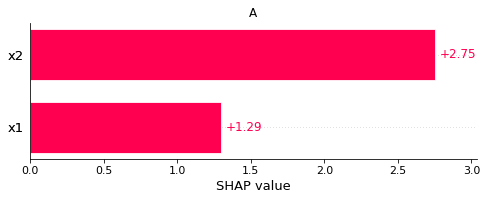

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

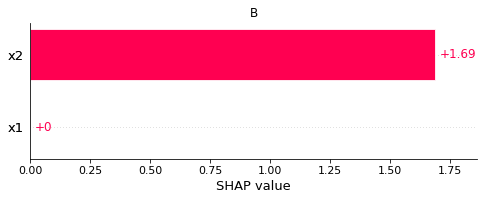

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 25.1 ms, sys: 4.04 ms, total: 29.1 ms
Wall time: 30.8 ms


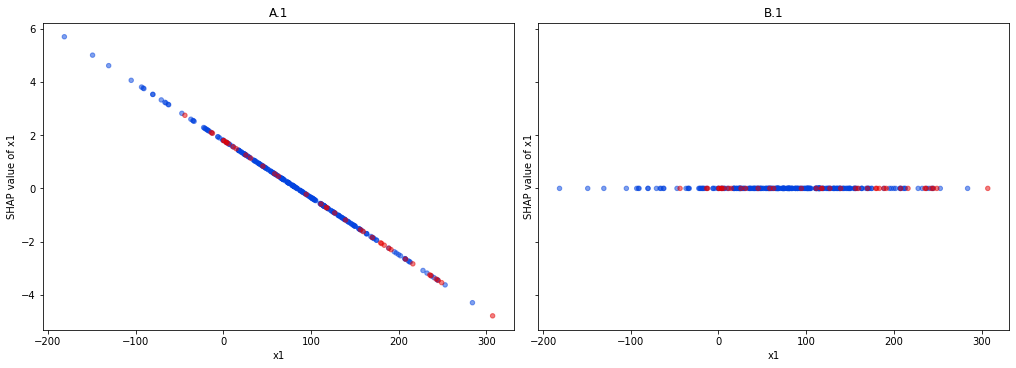

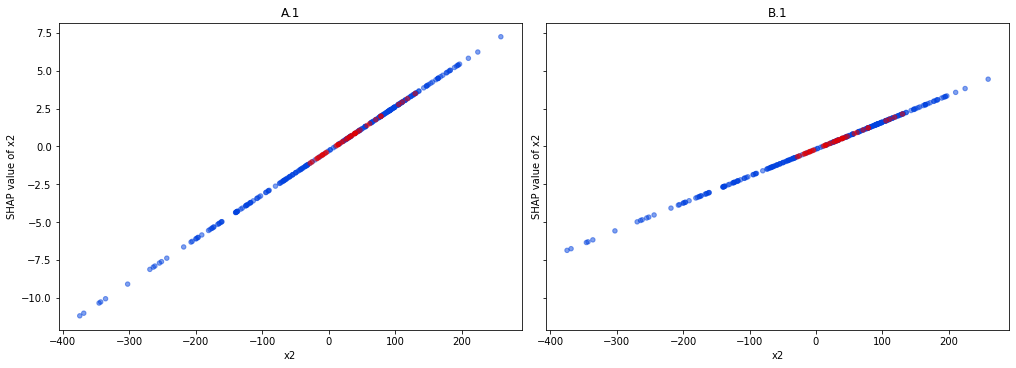

In [11]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [5]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

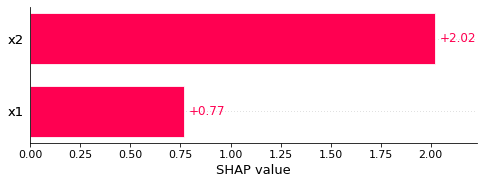

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

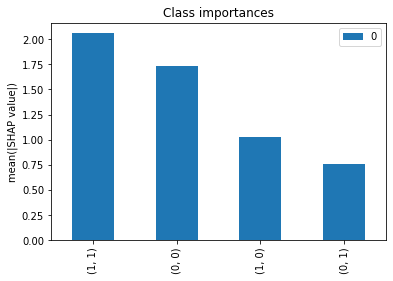

In [7]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [8]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 22.2 s, sys: 227 ms, total: 22.4 s
Wall time: 23.6 s


((1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 882.7363012595714)

In [9]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (R)

In [10]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (1, 1)    149
 (0, 0)     53
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 273.59492770205946)

There's a lower CF at 81. All charts show a linear relation between input and output, but with feature interactions causing different degrees of this relation to be present in each dependence plot.
- $(0,0)$: Dependence curve is monotonically increasing (positive correlation between feature values and SHAP values)
- $(0,1)$: Dependence curve is monotonically increasing, the red instances are located in the upper half, but not exclusively.
- $(1,1)$: Dependence curve is monotonically decreasing

94.55361439361346 <= x1
[Lower CF: x1 == 81.1 --> {'(1, 1)': 22}]


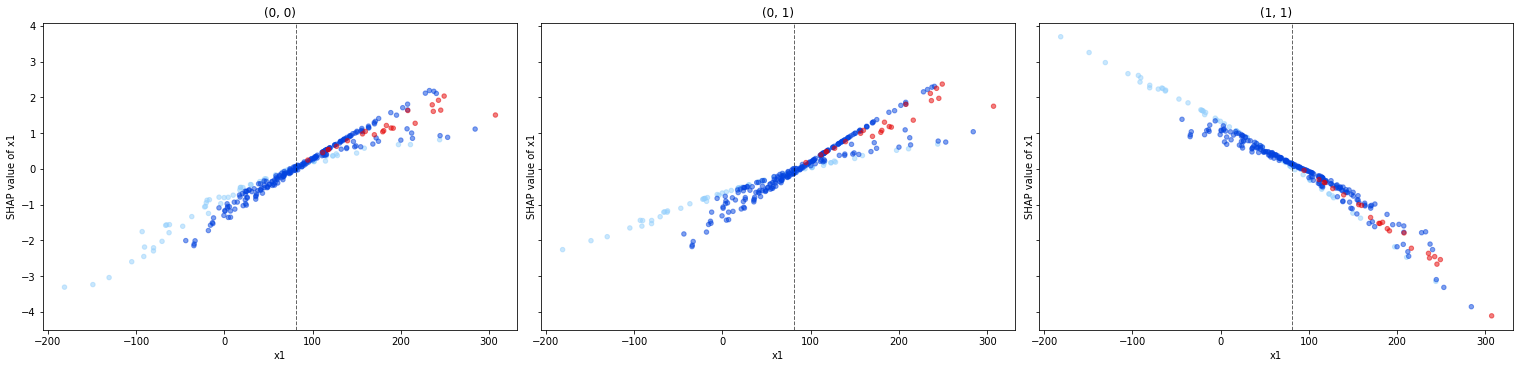

In [11]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

For x2, there are two counterfactuals. Here too, feature interaction is present which is responsible for the vertical spread of the SHAP values.
- $(0,0)$: Dependence curve is monotonically decreasing
- $(0,1)$: Dependence curve is monotonically increasing until ~0, where it is in a global high, then monotonically decreasing. Interestingly, the red instances are located more to the right from the top.
- $(1,1)$: Dependence curve is monotonically increasing

21.71322062603863 <= x2 <= 130.02506989441343
[Lower CF: x2 == 21.3 --> {'(0, 0)': 22},
 Upper CF: x2 == 188.5 --> {'(1, 1)': 22}]


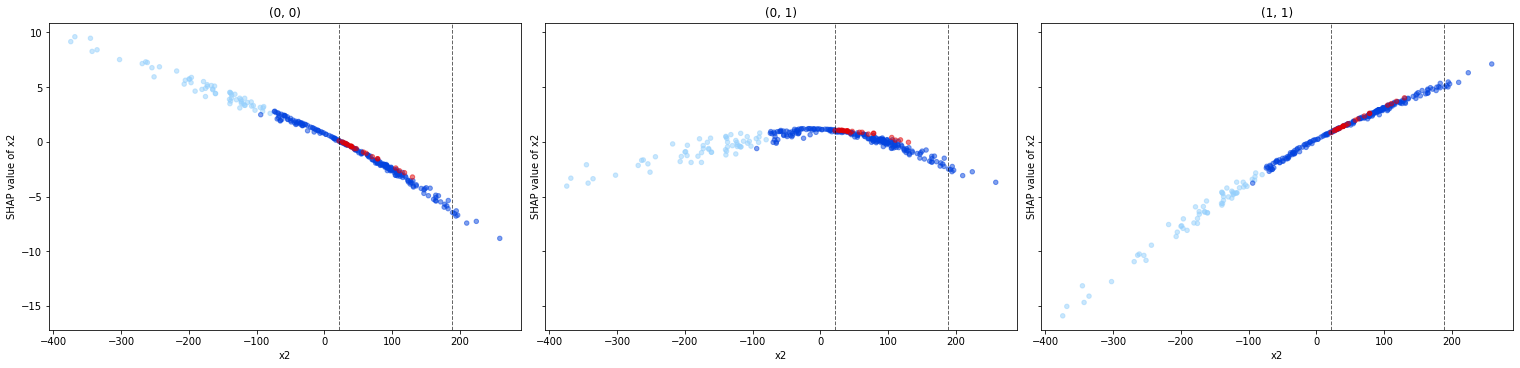

In [12]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

The vertical spread of the SHAP values indicates feature interactions and there seems to be structure to it. By coloring the plots by the other feature respectively, I can visualize that. In this simple case, it's clear which features are interacting, because there are only two.

For high values of x2, the dependence on x1 of both $(0,0)$ and $(0,1)$ are steeper while $(1,1)$ is less steep. For low values, the opposite is the case.

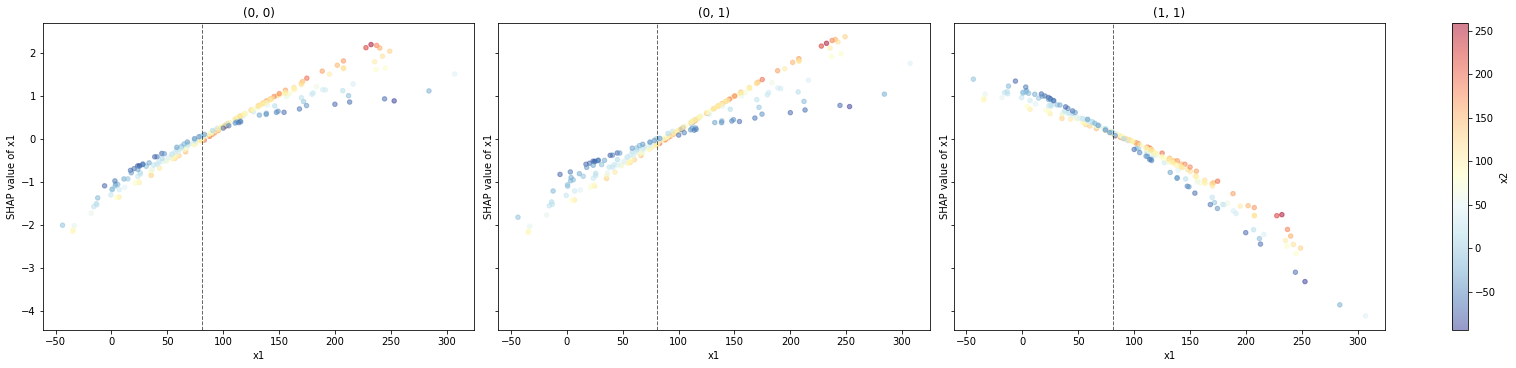

In [13]:
node.plot_feature_dependence('x1', alpha=0.5, color='x2')

For high values of x1, the dependence on x2 is steeper of $(1,1)$, less steep of $(0,0)$ and the highest point of influence on $(0,1)$ is higher, around 50.

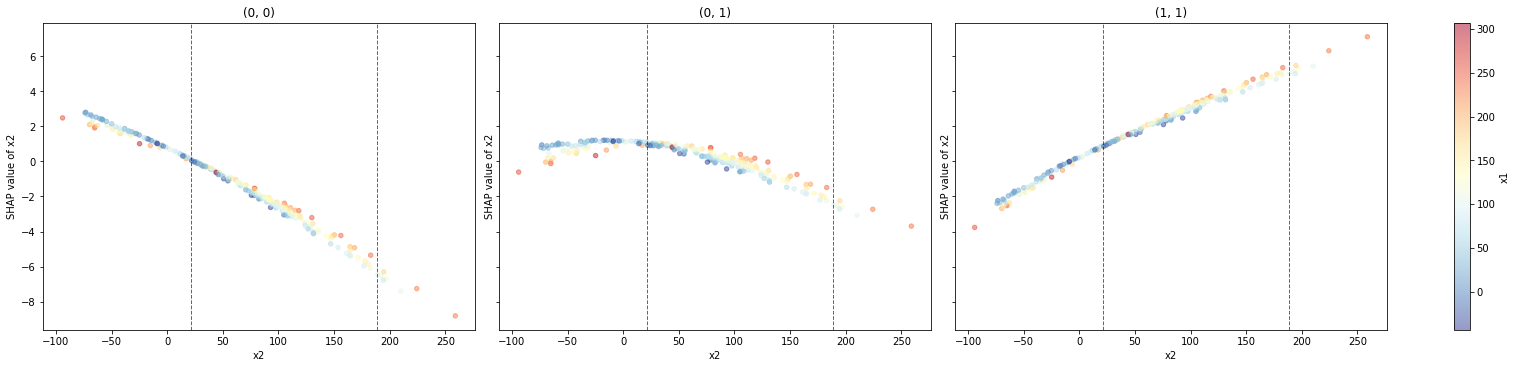

In [14]:
node.plot_feature_dependence('x2', alpha=0.5, color='x1')

21.3 < x2 <= 188.4 and x1 > 81.1
              precision    recall  f1-score   support

       False       1.00      0.65      0.78       217
        True       0.22      1.00      0.36        22

    accuracy                           0.68       239
   macro avg       0.61      0.82      0.57       239
weighted avg       0.93      0.68      0.75       239



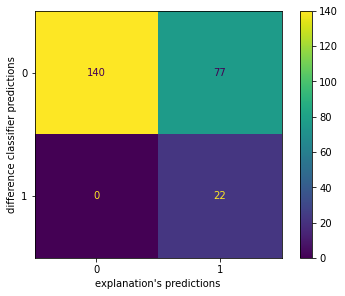

In [15]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [16]:
explanations_global = [(rule, constraint, instance_indices)]

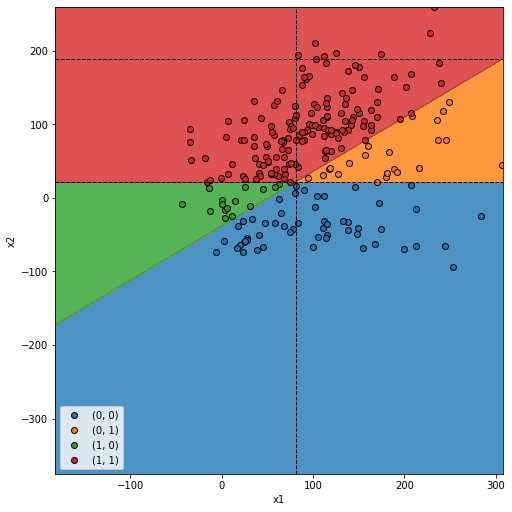

In [17]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 1 (RLLRL)

The left child nodes contains 4 instances classified $(0,1)$, and next I will analyze the last node before they are split up.

In [18]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLLRL,
 (0, 1)    4
 (1, 1)    2
 dtype: int64,
 2.752378495218214)

To understand, how far these 4 instances classified $(0,1)$ are from being predicted as $(0,0)$ or $(1,1)$, I plot the log odds outcome differences. A value above zero means, that the comparison class log odds outcome is higher than the $(0,1)$ log odds outcome, as for the two instances in orange on the right, which are actually classified $(1,1)$. I can see, that the instances classified $(0,1)$ are closer to $(1,1)$ in terms of log odds than to $(0,0)$. And I can see, that this is in line with the 2 instances in this cluster, that are not classified $(0,1)$. They act as a comparison group, and might as well be treated as naturally occuring counterfactual instances. Later in the dependence plots, I can check what differentiates them from the group of instances classified $(0,1)$.

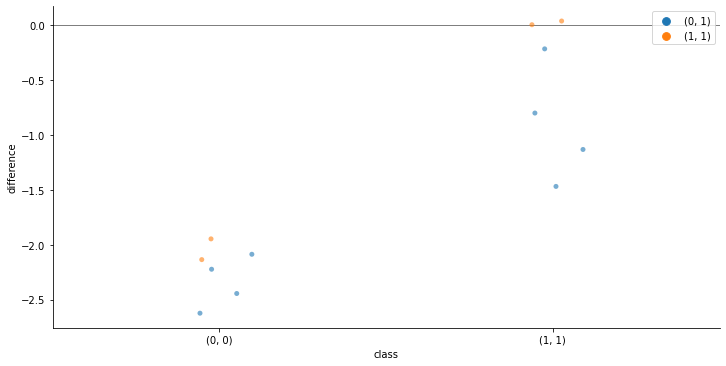

{'(0, 0)': '-2.62 to -2.09', '(1, 1)': '-1.47 to -0.22'}


In [19]:
node.plot_outcome_differences()

Just for completeness, below you can see the log odds difference distribution of the data set.

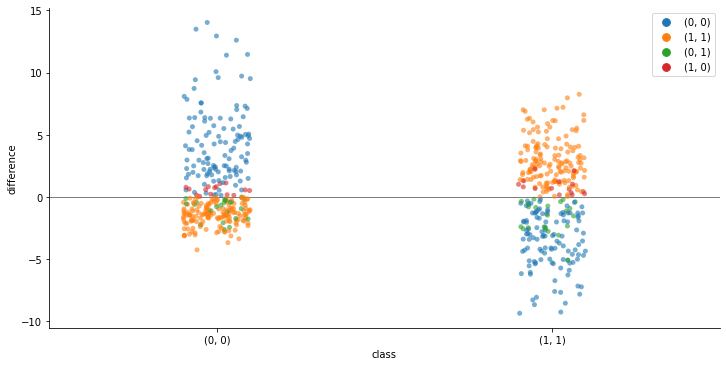

{'(0, 0)': '-2.62 to -0.01', '(1, 1)': '-5.09 to -0.18'}


In [20]:
node.root.plot_outcome_differences()

The lower CF is higher than that of the parent.

207.88011354547447 <= x1 <= 249.04127642882824
[Lower CF: x1 == 194.5 --> {'(1, 1)': 4}]


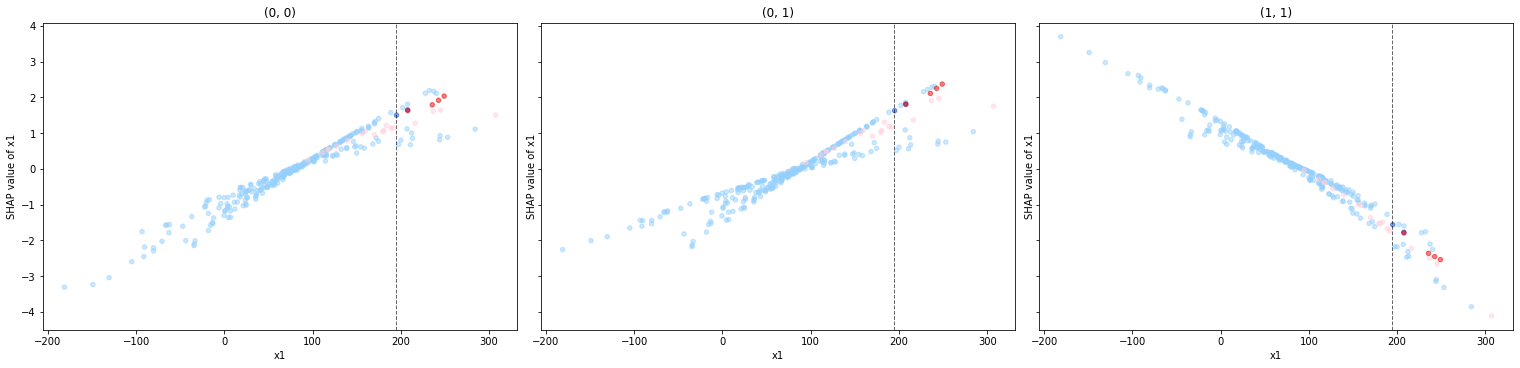

In [21]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

The upper CF is lower than that of the parent.

105.35039011208185 <= x2 <= 130.02506989441343
[Lower CF: x2 == 21.3 --> {'(0, 0)': 4},
 Upper CF: x2 == 145.6 --> {'(1, 1)': 4}]


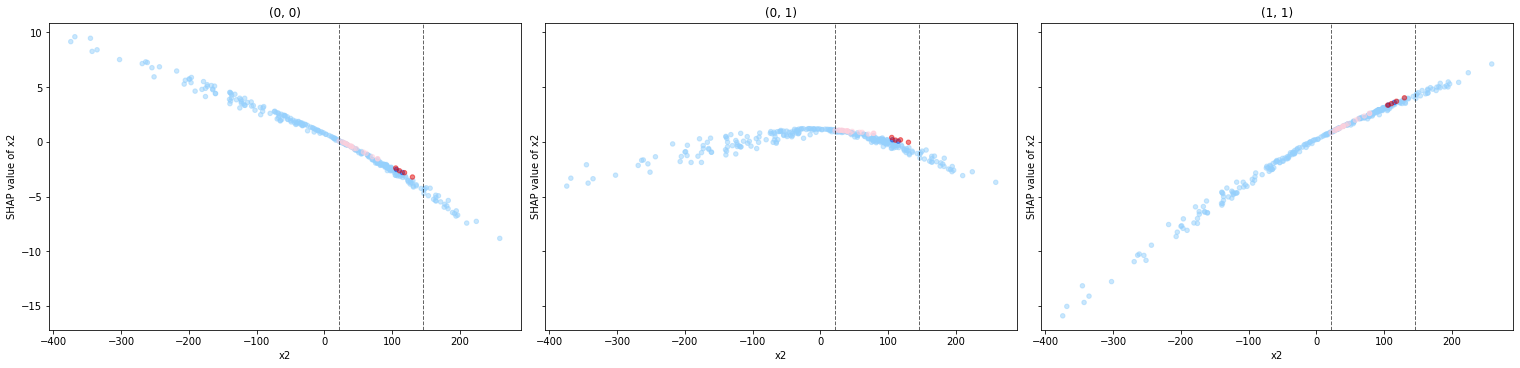

In [22]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

21.3 < x2 <= 145.5 and x1 > 194.5
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         2
        True       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


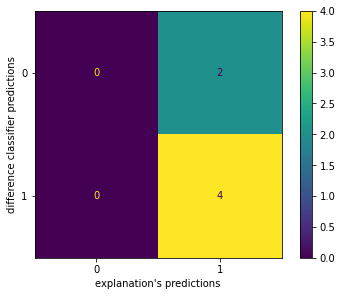

In [23]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [24]:
explanations_l1 = [(rule, constraint, instance_indices)]

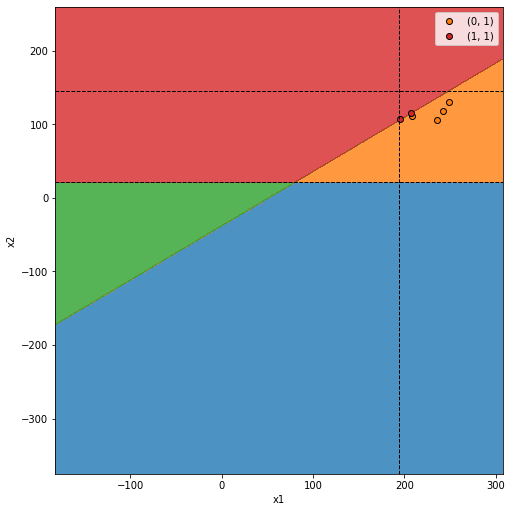

In [25]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2 (RRLR)

In [26]:
node = node.root.get('RR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLR,
 (1, 1)    49
 (0, 1)    18
 (0, 0)    11
 (1, 0)     3
 dtype: int64,
 36.219047895379745)

Compared to the last node I interpreted, this has a high distance.

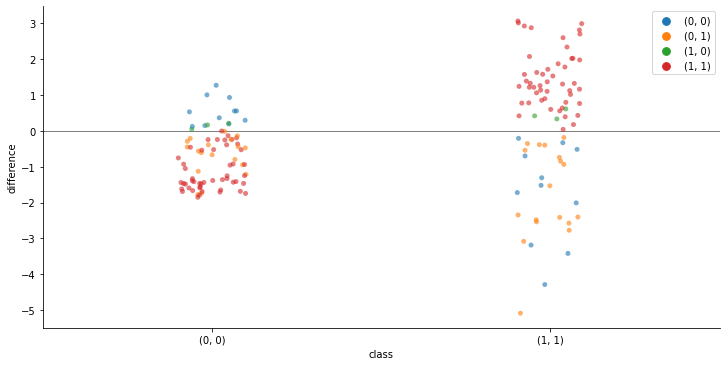

{'(0, 0)': '-1.78 to -0.01', '(1, 1)': '-5.09 to -0.18'}


In [27]:
node.plot_outcome_differences()

CF equal to parent

94.55361439361346 <= x1
[Lower CF: x1 == 81.1 --> {'(1, 1)': 18}]


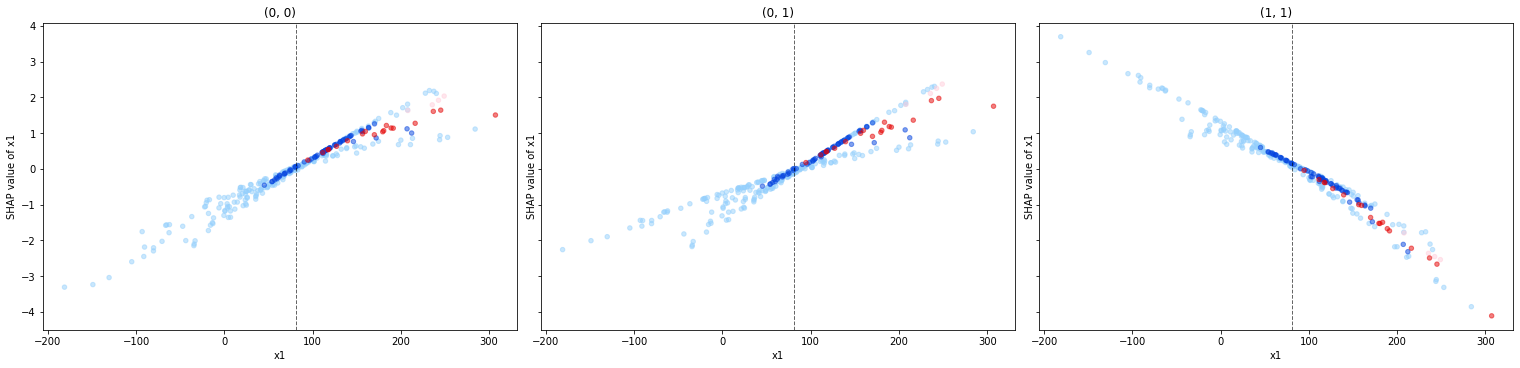

In [28]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

CFs equal to parent

21.71322062603863 <= x2 <= 78.69646042050337
[Lower CF: x2 == 21.3 --> {'(0, 0)': 18},
 Upper CF: x2 == 188.5 --> {'(1, 1)': 18}]


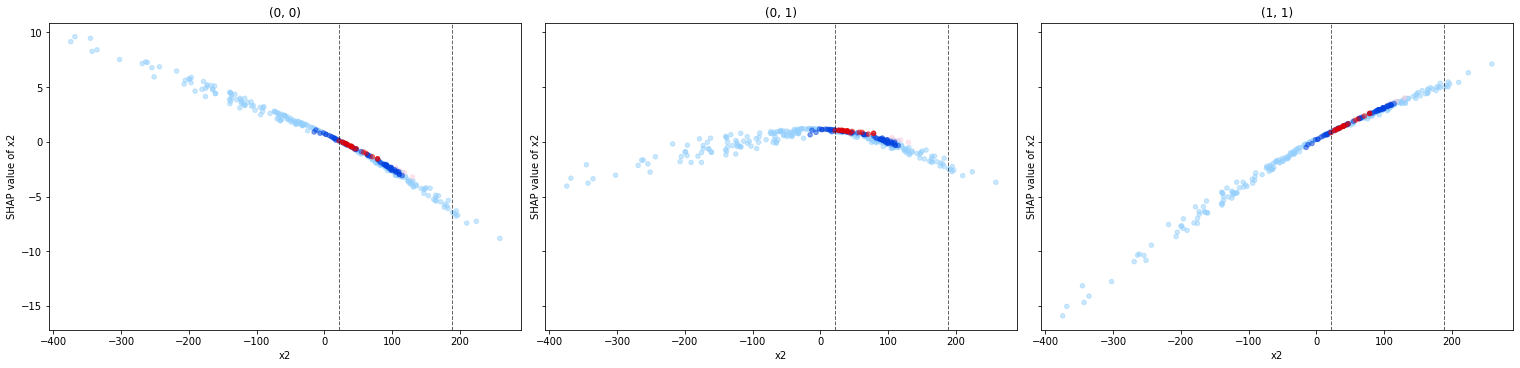

In [29]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

21.3 < x2 <= 188.4 and x1 > 81.1
              precision    recall  f1-score   support

       False       1.00      0.41      0.58        63
        True       0.33      1.00      0.49        18

    accuracy                           0.54        81
   macro avg       0.66      0.71      0.54        81
weighted avg       0.85      0.54      0.56        81



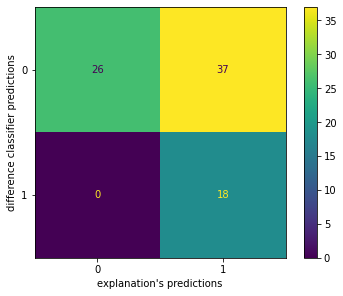

In [30]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [31]:
explanations_l1.append((rule, constraint, instance_indices))

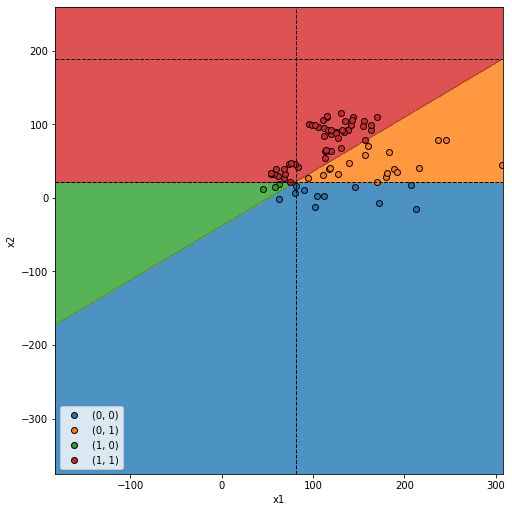

In [32]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.1 (RRLRL)

In [33]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRL,
 (1, 1)    13
 (0, 1)    11
 (0, 0)    11
 (1, 0)     3
 dtype: int64,
 16.081186720830175)

Still, the distance is rather high.

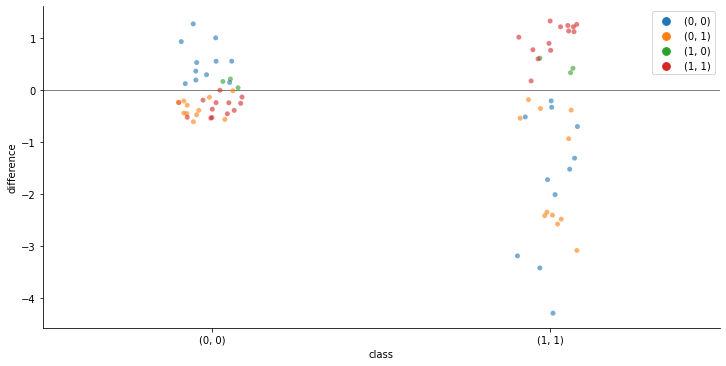

{'(0, 0)': '-0.61 to -0.01', '(1, 1)': '-3.08 to -0.18'}


In [34]:
node.plot_outcome_differences()

CF equal to parent

94.55361439361346 <= x1 <= 216.1911730686155
[Lower CF: x1 == 81.1 --> {'(1, 1)': 11}]


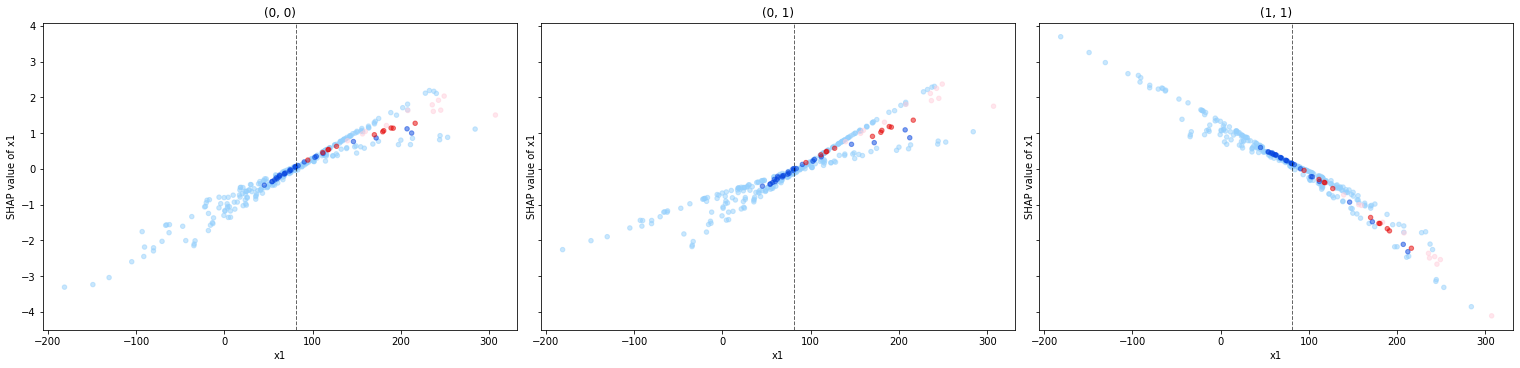

In [35]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

upper CF now lower

21.71322062603863 <= x2 <= 40.42060515353158
[Lower CF: x2 == 21.3 --> {'(0, 0)': 11},
 Upper CF: x2 == 121.4 --> {'(1, 1)': 11}]


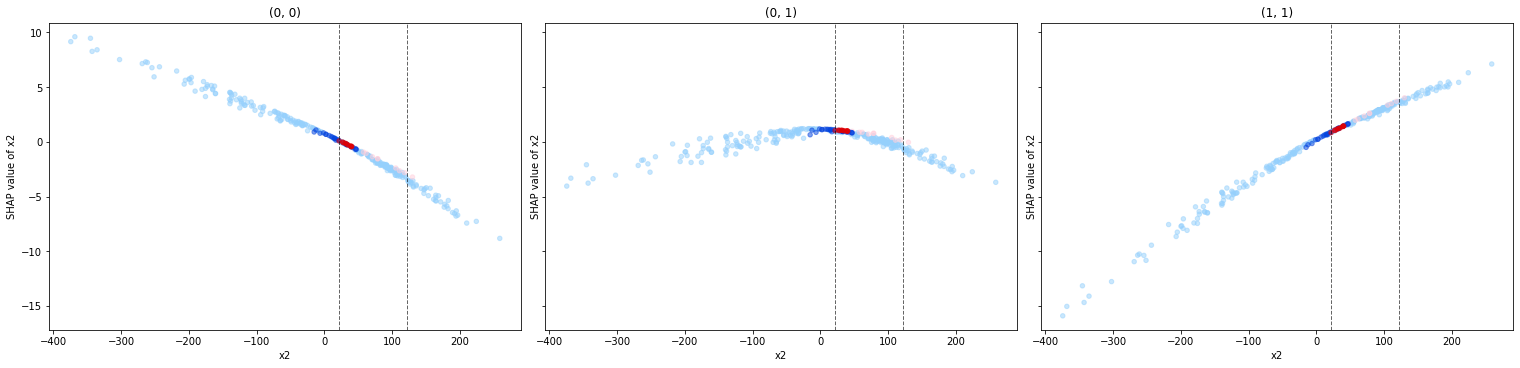

In [36]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

21.3 < x2 <= 121.3 and x1 > 81.1
              precision    recall  f1-score   support

       False       1.00      0.96      0.98        27
        True       0.92      1.00      0.96        11

    accuracy                           0.97        38
   macro avg       0.96      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



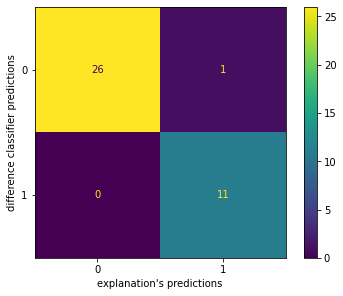

In [37]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [38]:
explanations_l2 = [explanations_l1[0], (rule, constraint, instance_indices)]

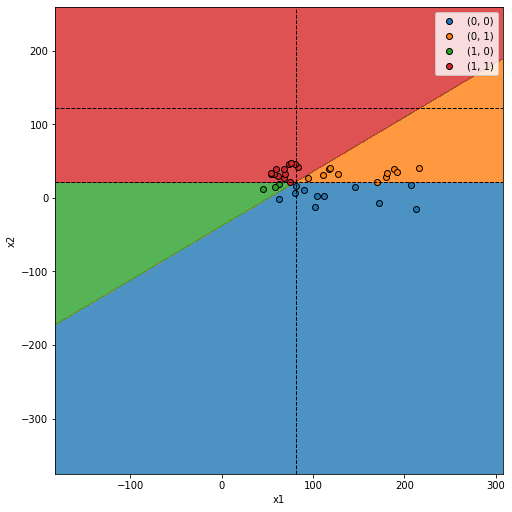

In [39]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.1.1 (RRLRLLR)

In [40]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRLLR,
 (0, 1)    6
 (0, 0)    2
 dtype: int64,
 3.565646207734325)

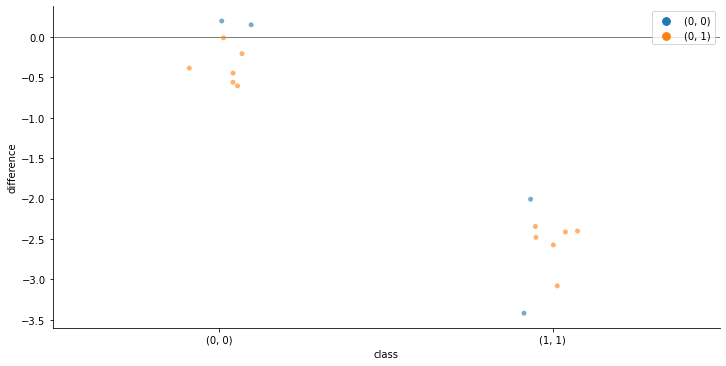

{'(0, 0)': '-0.61 to -0.01', '(1, 1)': '-3.08 to -2.35'}


In [41]:
node.plot_outcome_differences()

CF equal to parent

169.96479241673015 <= x1 <= 216.1911730686155
[Lower CF: x1 == 81.1 --> {'(1, 1)': 6}]


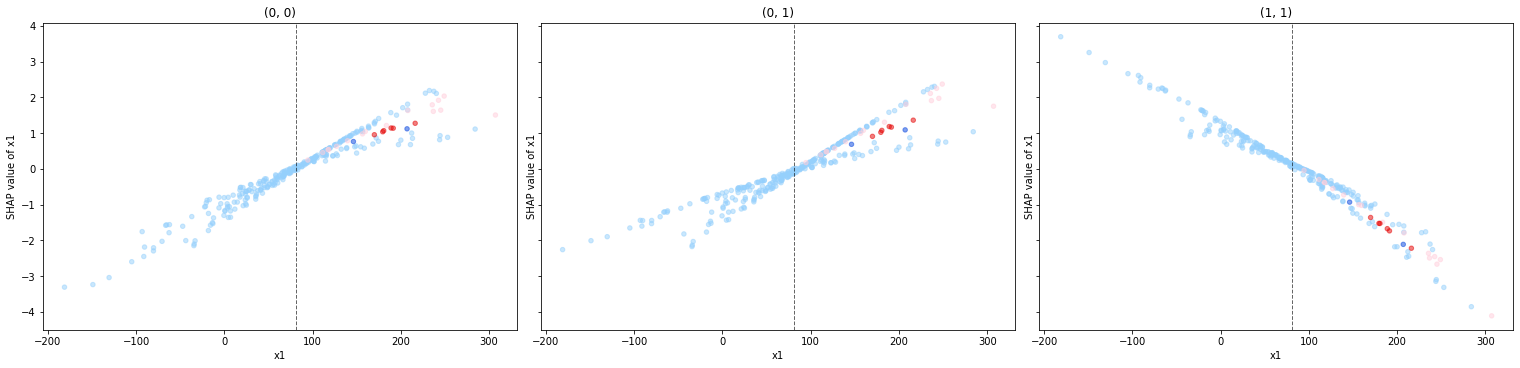

In [42]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

CF equal to parent

21.71322062603863 <= x2 <= 39.793865327223976
[Lower CF: x2 == 21.3 --> {'(0, 0)': 6},
 Upper CF: x2 == 121.4 --> {'(1, 1)': 6}]


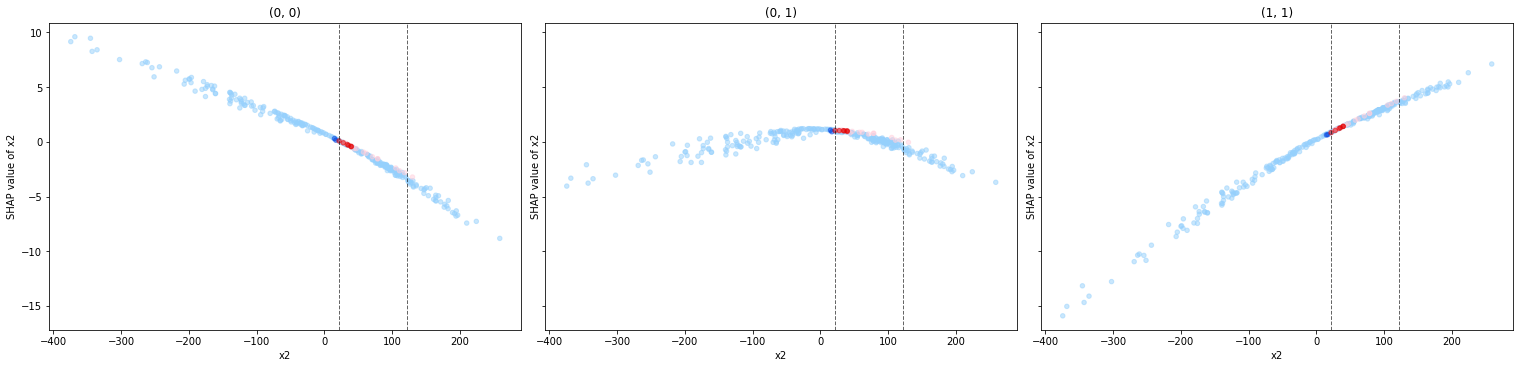

In [43]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

x1 > 81.1 and 21.3 < x2 <= 121.3
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         2
        True       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



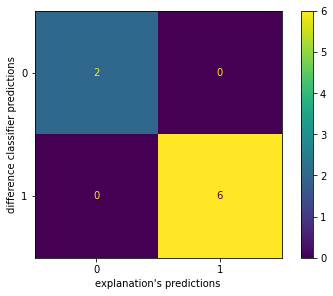

In [44]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [45]:
explanations_l3 = explanations_l2[:-1] + [(rule, constraint, instance_indices)]

### Node 2.1.1.1 (RRLRLLRLR)

In [46]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRLLRLR,
 (0, 1)    1
 dtype: int64,
 0)

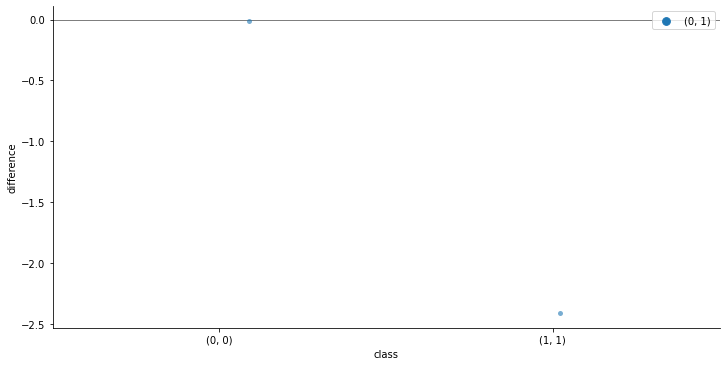

{'(0, 0)': '-0.01 to -0.01', '(1, 1)': '-2.41 to -2.41'}


In [47]:
node.plot_outcome_differences()

CF equal to parent

x1 == 169.96479241673015
[Lower CF: x1 == 81.1 --> {'(1, 1)': 1}]


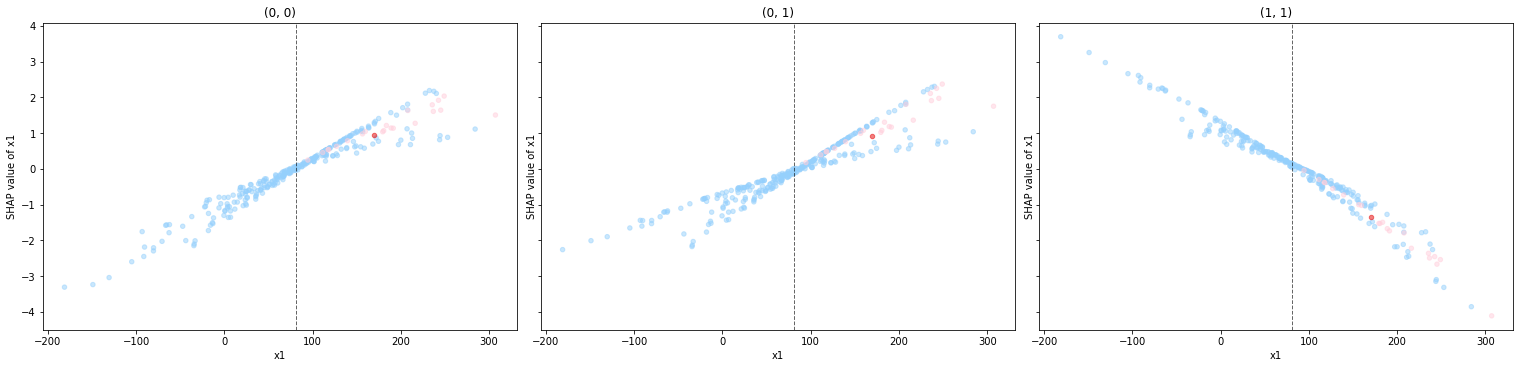

In [48]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

upper CF now lower

x2 == 21.71322062603863
[Lower CF: x2 == 21.3 --> {'(0, 0)': 1}, Upper CF: x2 == 87.3 --> {'(1, 1)': 1}]


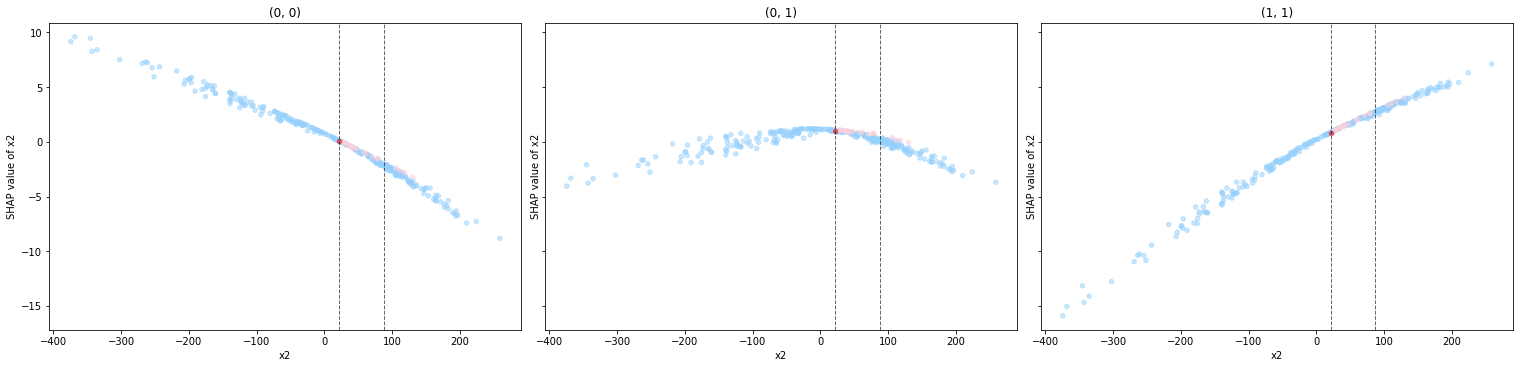

In [49]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

x1 > 81.1 and 21.3 < x2 <= 87.2
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



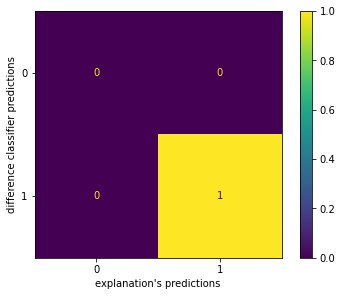

In [50]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [51]:
explanations_l4 = explanations_l3[:-1] + [(rule, constraint, instance_indices)]

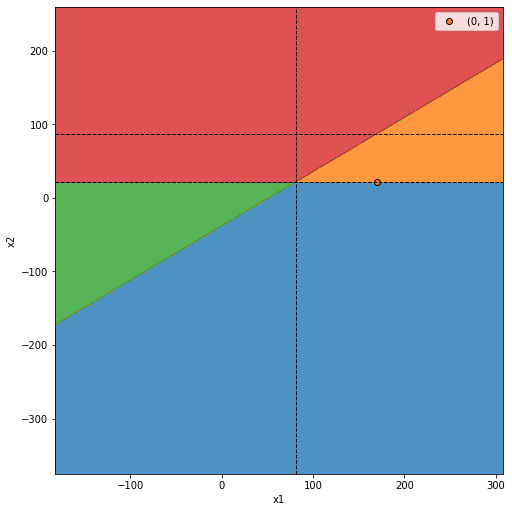

In [52]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.1.1.2 (RRLRLLRRR)

In [53]:
node = node.get_parent(2).get_right().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRLLRRR,
 (0, 1)    5
 dtype: int64,
 0.9278504135476936)

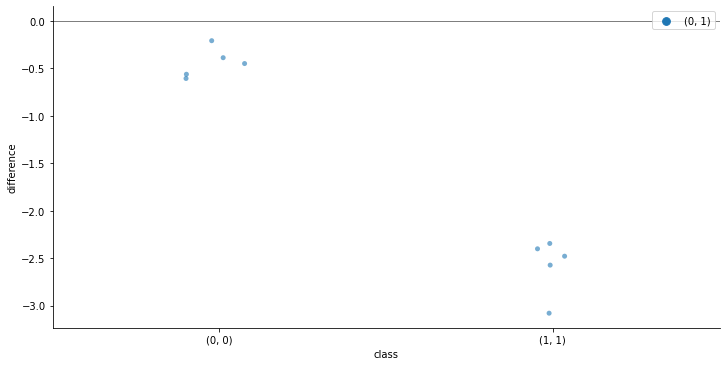

{'(0, 0)': '-0.61 to -0.21', '(1, 1)': '-3.08 to -2.35'}


In [54]:
node.plot_outcome_differences()

CF closer than that of parent.

179.42256345280322 <= x1 <= 216.1911730686155
[Lower CF: x1 == 89.5 --> {'(1, 1)': 5}]


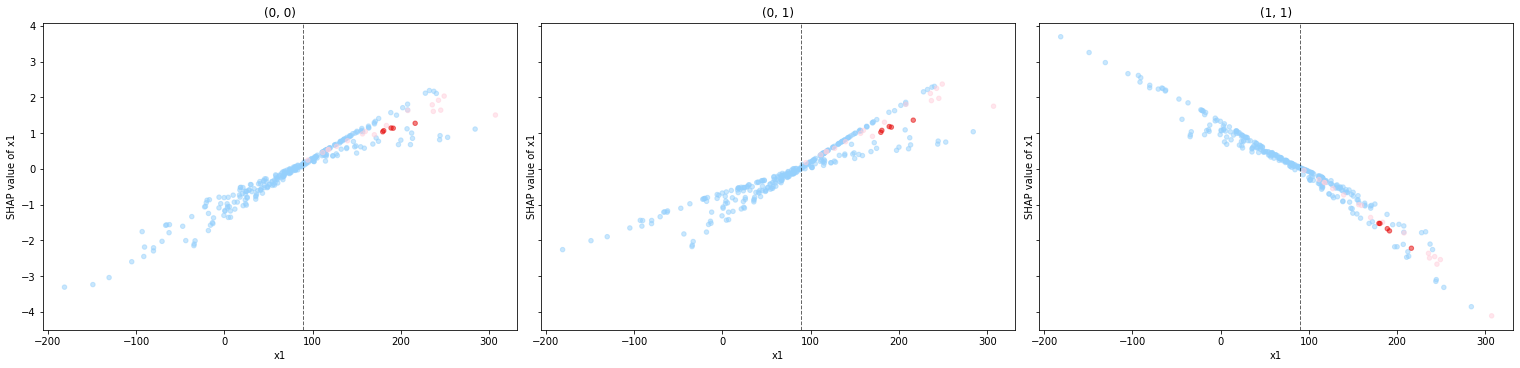

In [55]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

CFs equal to those of parent.

27.9033330838305 <= x2 <= 39.793865327223976
[Lower CF: x2 == 21.3 --> {'(0, 0)': 5},
 Upper CF: x2 == 121.4 --> {'(1, 1)': 5}]


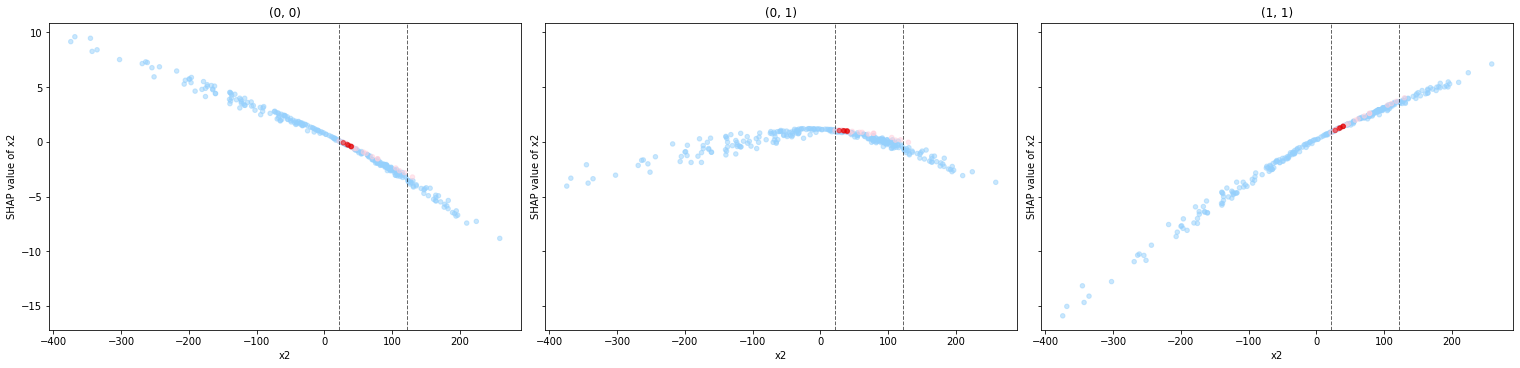

In [56]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

x1 > 89.5 and 21.3 < x2 <= 121.3
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



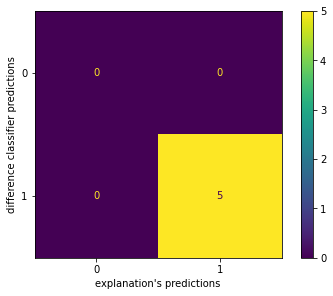

In [57]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [58]:
explanations_l4.append((rule, constraint, instance_indices))

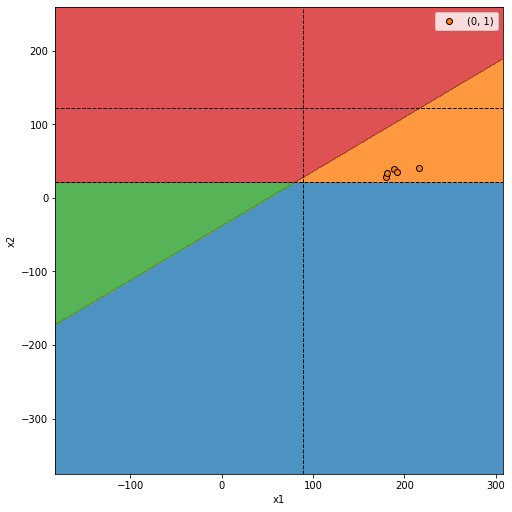

In [59]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.1.2 (RRLRLRRR)

In [60]:
node = node.root.get('RRLRLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRLRRR,
 (0, 1)    5
 (1, 1)    1
 (0, 0)    1
 dtype: int64,
 1.8236273378078334)

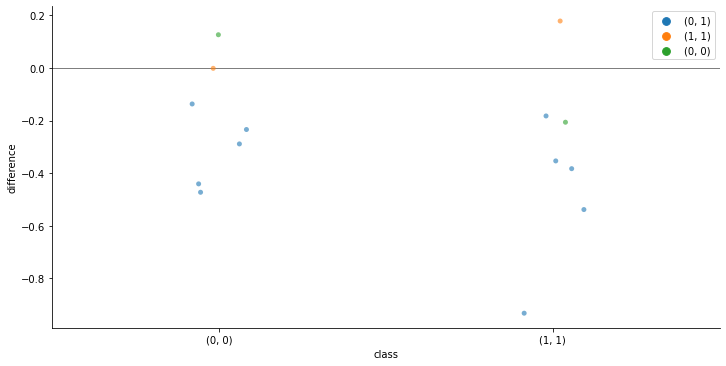

{'(0, 0)': '-0.47 to -0.14', '(1, 1)': '-0.93 to -0.18'}


In [61]:
node.plot_outcome_differences()

lower CF now higher

94.55361439361346 <= x1 <= 127.11742133952461
[Lower CF: x1 == 88.2 --> {'(1, 1)': 5}]


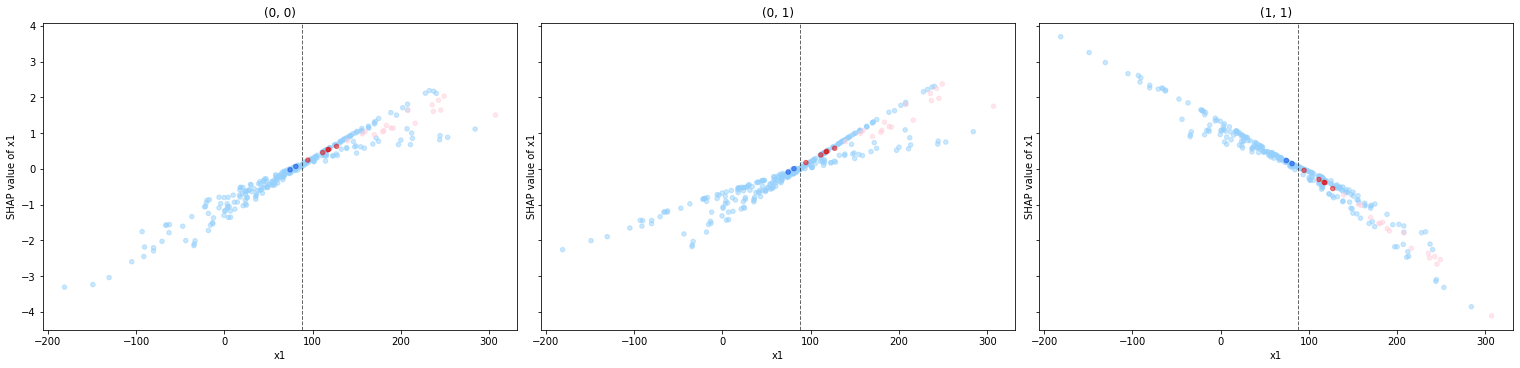

In [62]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

upper CF now lower

26.970401508651175 <= x2 <= 40.42060515353158
[Lower CF: x2 == 21.3 --> {'(0, 0)': 5}, Upper CF: x2 == 55.7 --> {'(1, 1)': 5}]


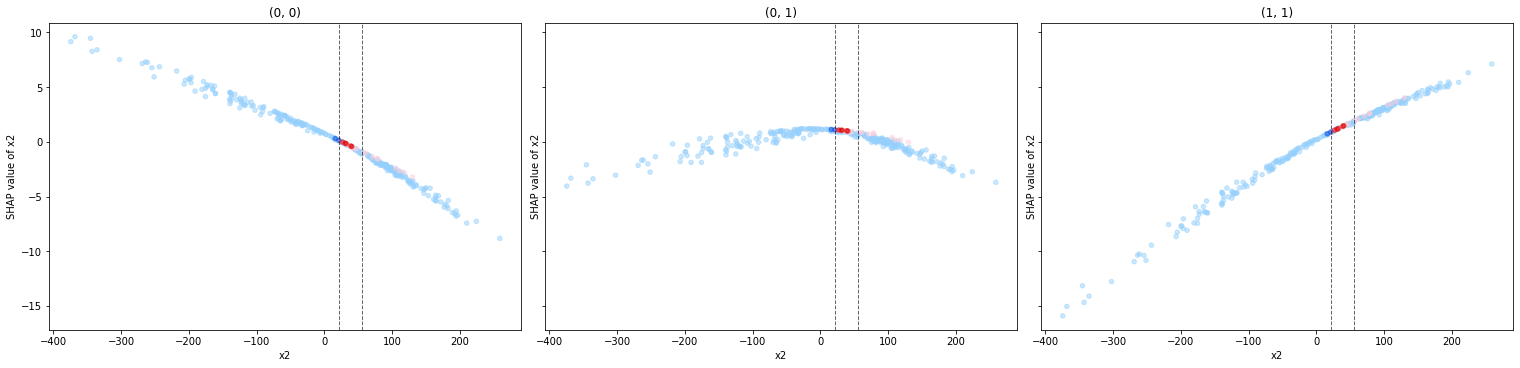

In [63]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

21.3 < x2 <= 55.6 and x1 > 88.2
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         2
        True       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



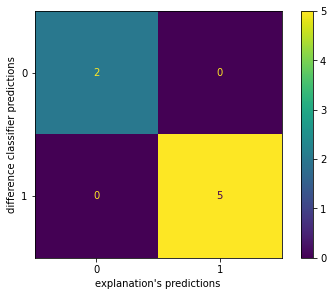

In [64]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [65]:
explanations_l3.append((rule, constraint, instance_indices))
explanations_l4.append((rule, constraint, instance_indices))

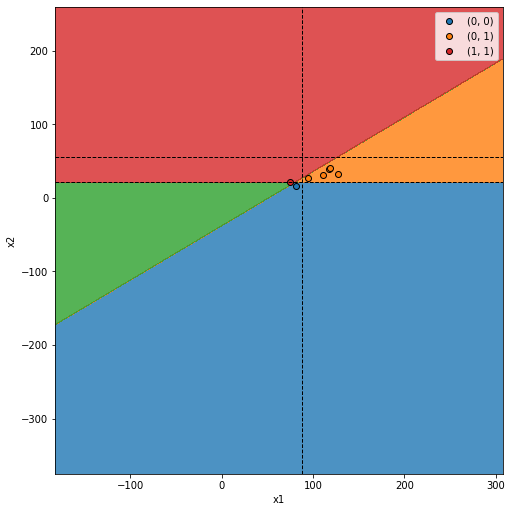

In [66]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.2 (RRLRR)

In [67]:
node = node.root.get('RRLRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRR,
 (1, 1)    36
 (0, 1)     7
 dtype: int64,
 28.04230560856923)

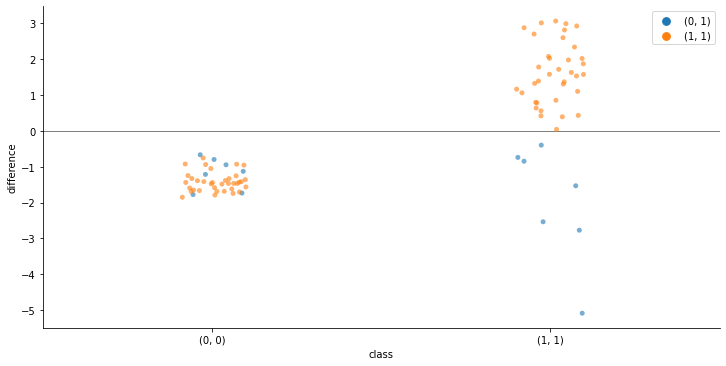

{'(0, 0)': '-1.78 to -0.66', '(1, 1)': '-5.09 to -0.4'}


In [68]:
node.plot_outcome_differences()

lower CF now higher

139.48436302869598 <= x1
[Lower CF: x1 == 111.3 --> {'(1, 1)': 7}]


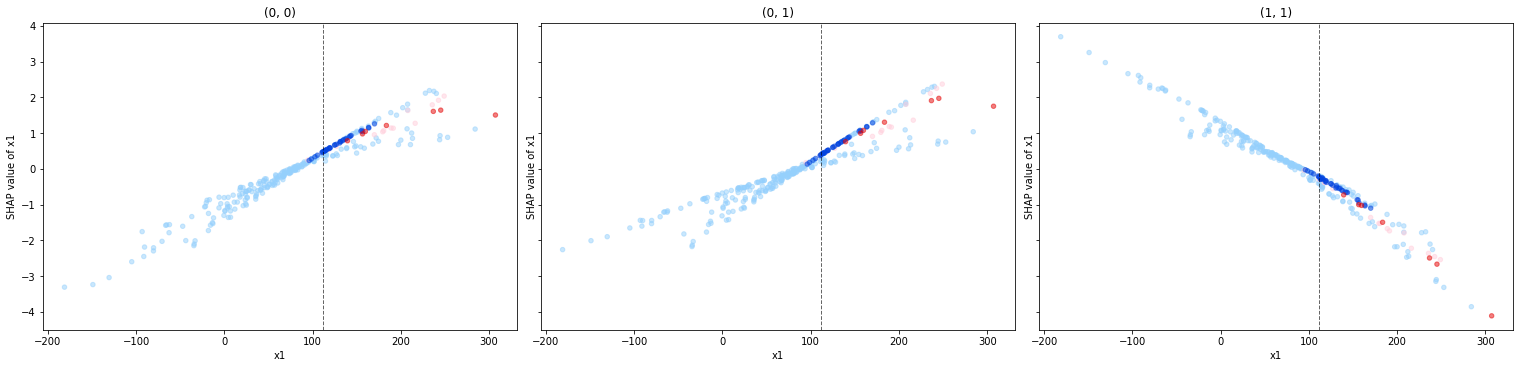

In [69]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

CFs equal to parent

43.996255745135436 <= x2 <= 78.69646042050337
[Lower CF: x2 == 21.3 --> {'(0, 0)': 7},
 Upper CF: x2 == 188.5 --> {'(1, 1)': 7}]


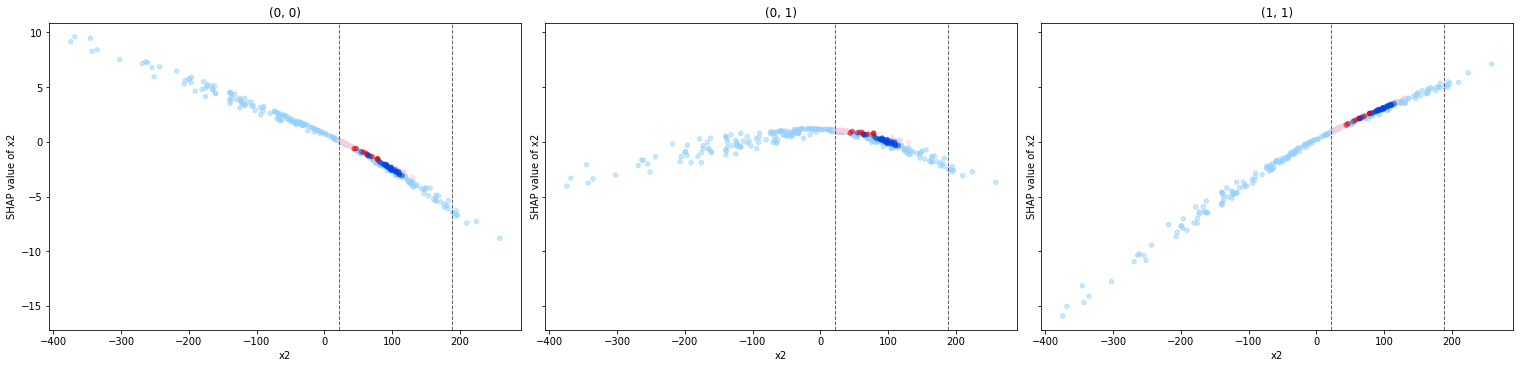

In [70]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

21.3 < x2 <= 188.4 and x1 > 111.3
              precision    recall  f1-score   support

       False       1.00      0.14      0.24        36
        True       0.18      1.00      0.31         7

    accuracy                           0.28        43
   macro avg       0.59      0.57      0.28        43
weighted avg       0.87      0.28      0.25        43



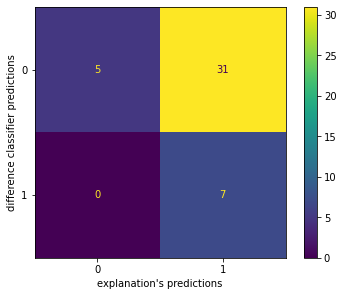

In [71]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [72]:
explanations_l2.append((rule, constraint, instance_indices))

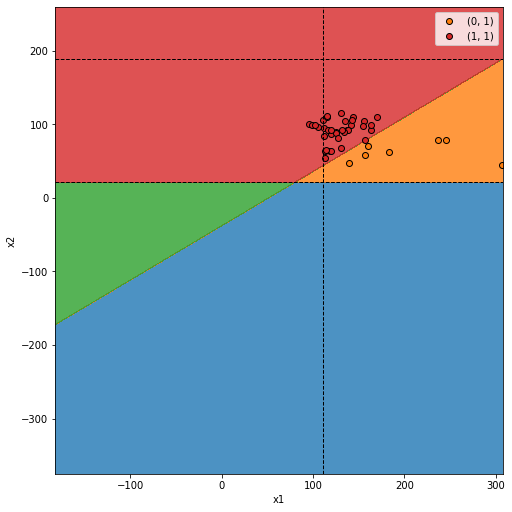

In [73]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.2.1 (RRLRRL)

In [74]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRRL,
 (0, 1)    3
 dtype: int64,
 4.611529916290334)

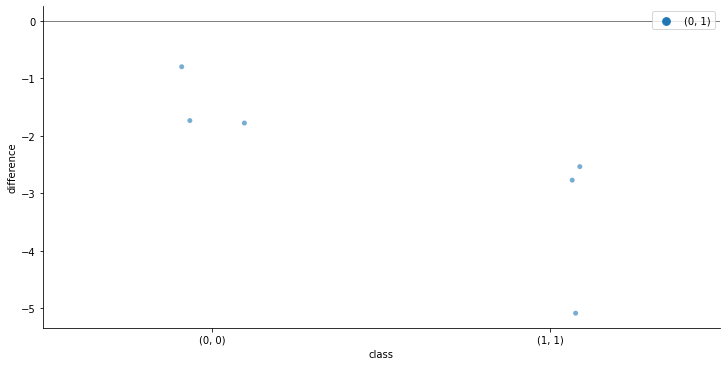

{'(0, 0)': '-1.78 to -0.8', '(1, 1)': '-5.09 to -2.54'}


In [75]:
node.plot_outcome_differences()

CF equal to parent

236.75428302388113 <= x1
[Lower CF: x1 == 111.3 --> {'(1, 1)': 3}]


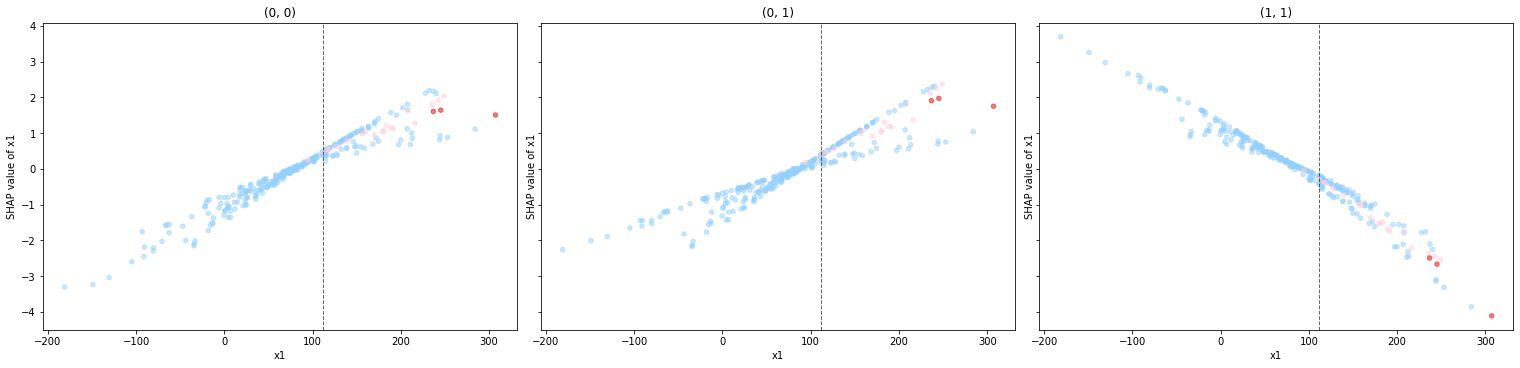

In [76]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

CFs equal to parent

43.996255745135436 <= x2 <= 78.69646042050337
[Lower CF: x2 == 21.3 --> {'(0, 0)': 3},
 Upper CF: x2 == 188.5 --> {'(1, 1)': 3}]


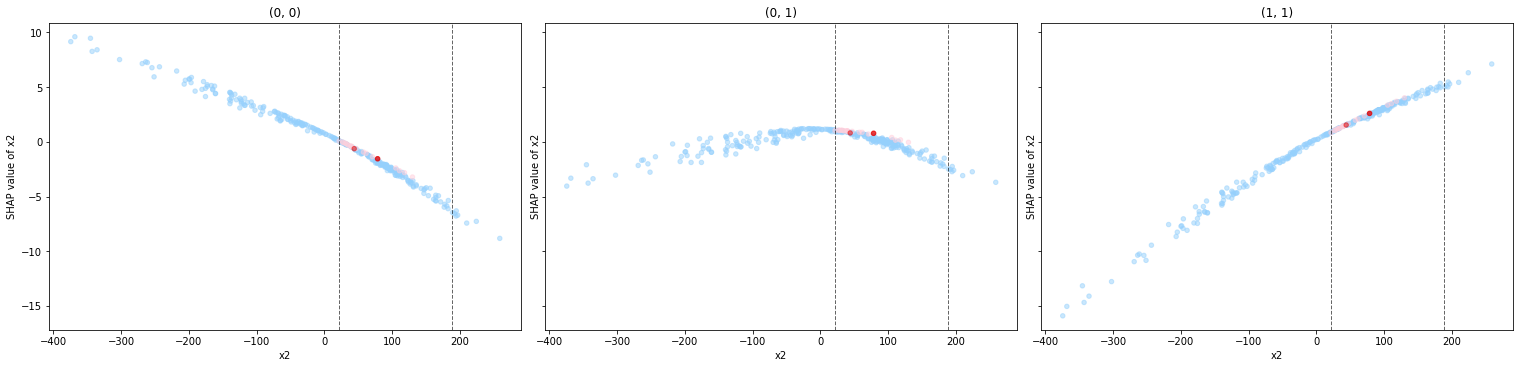

In [77]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

x1 > 111.3 and 21.3 < x2 <= 188.4
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



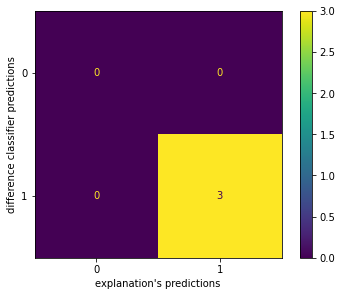

In [78]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [79]:
explanations_l3.append((rule, constraint, instance_indices))
explanations_l4.append((rule, constraint, instance_indices))

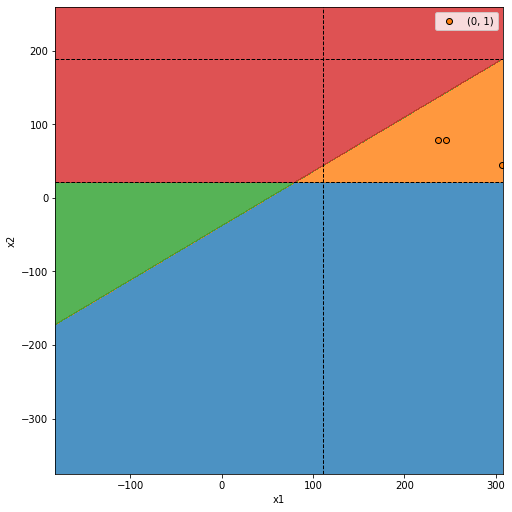

In [80]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2.2.2 (RRLRRRL)

In [81]:
node = node.parent.get_right().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRLRRRL,
 (1, 1)    7
 (0, 1)    4
 dtype: int64,
 2.8133220969837396)

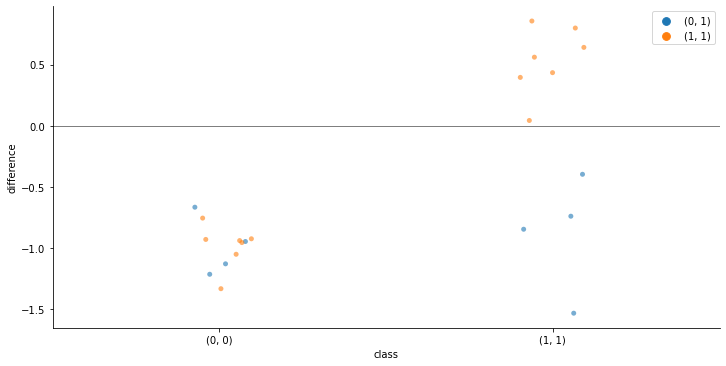

{'(0, 0)': '-1.21 to -0.66', '(1, 1)': '-1.53 to -0.4'}


In [82]:
node.plot_outcome_differences()

lower CF now higher

139.48436302869598 <= x1 <= 183.57246002956597
[Lower CF: x1 == 115.4 --> {'(1, 1)': 4}]


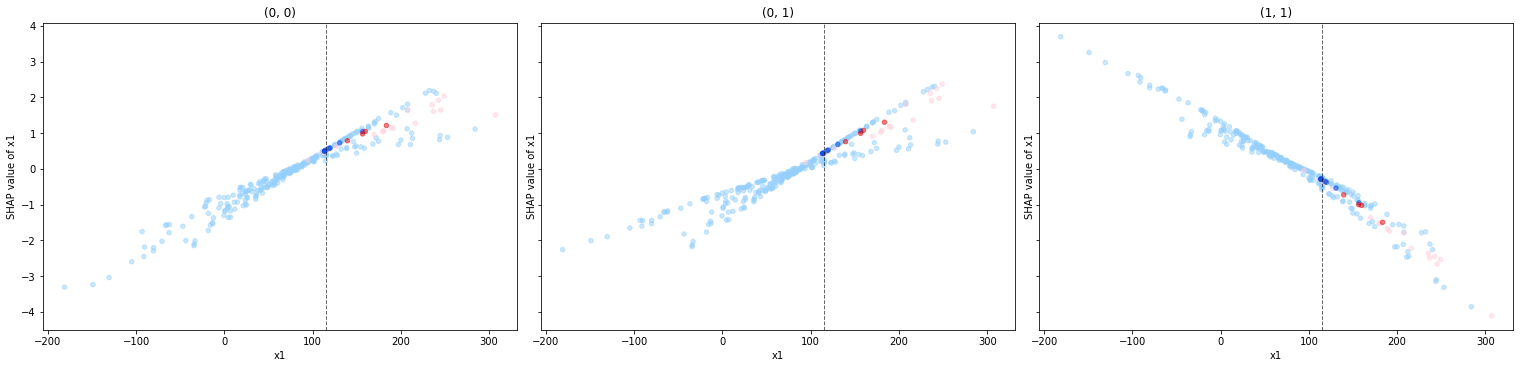

In [83]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

upper CF now lower

47.04445250884422 <= x2 <= 70.8584634570066
[Lower CF: x2 == 21.3 --> {'(0, 0)': 4}, Upper CF: x2 == 97.3 --> {'(1, 1)': 4}]


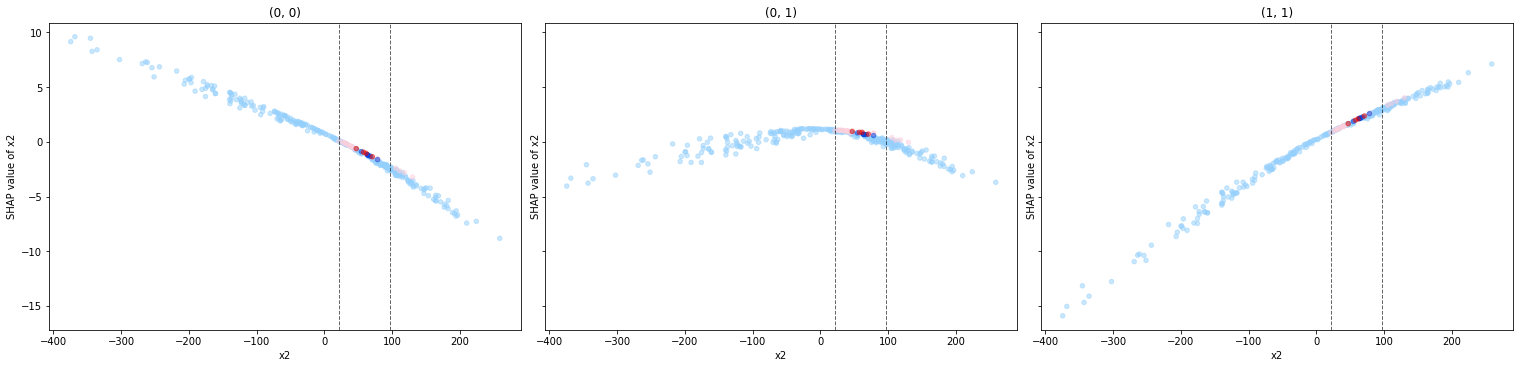

In [84]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

21.3 < x2 <= 97.2 and x1 > 115.4
              precision    recall  f1-score   support

       False       1.00      0.43      0.60         7
        True       0.50      1.00      0.67         4

    accuracy                           0.64        11
   macro avg       0.75      0.71      0.63        11
weighted avg       0.82      0.64      0.62        11



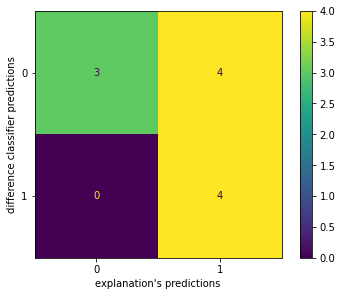

In [85]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [86]:
explanations_l3.append((rule, constraint, instance_indices))
explanations_l4.append((rule, constraint, instance_indices))

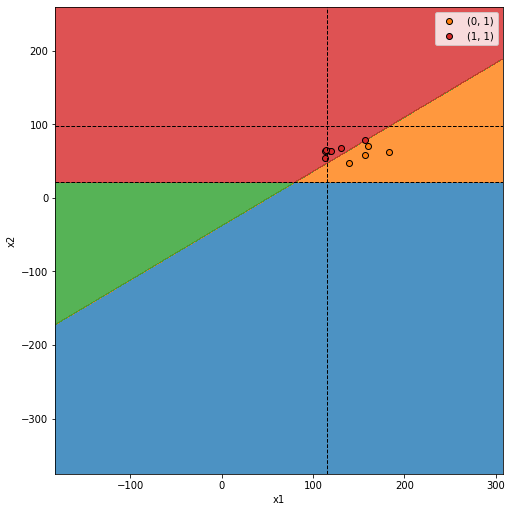

In [87]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Evaluation

#### Global Fidelity

##### Global

In [88]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

1. 21.3 < x2 <= 188.4 and x1 > 81.1
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       278
        True       0.22      1.00      0.36        22

    accuracy                           0.74       300
   macro avg       0.61      0.86      0.60       300
weighted avg       0.94      0.74      0.80       300



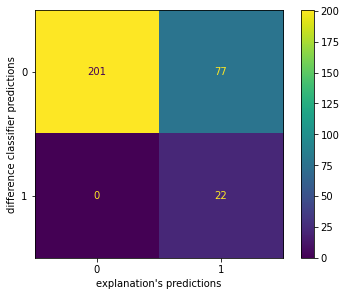

In [89]:
print_rules(rules)
node.root.evaluate_rules(*rules)

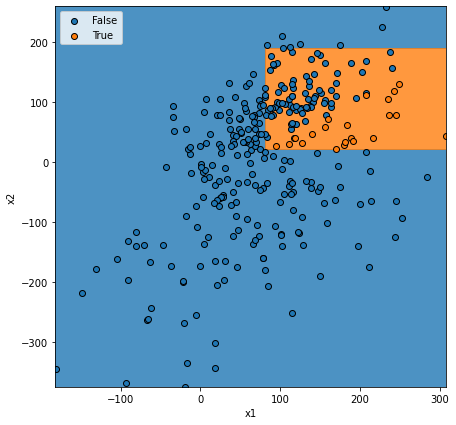

In [90]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

##### Level 1

In [91]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

1. 21.3 < x2 <= 145.5 and x1 > 194.5
2. 21.3 < x2 <= 188.4 and x1 > 81.1
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       278
        True       0.22      1.00      0.36        22

    accuracy                           0.74       300
   macro avg       0.61      0.86      0.60       300
weighted avg       0.94      0.74      0.80       300



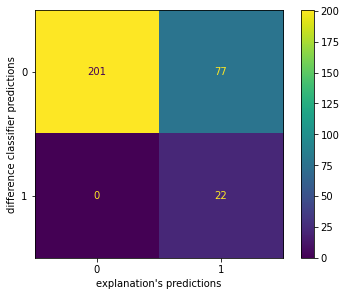

In [92]:
print_rules(rules)
node.root.evaluate_rules(*rules)

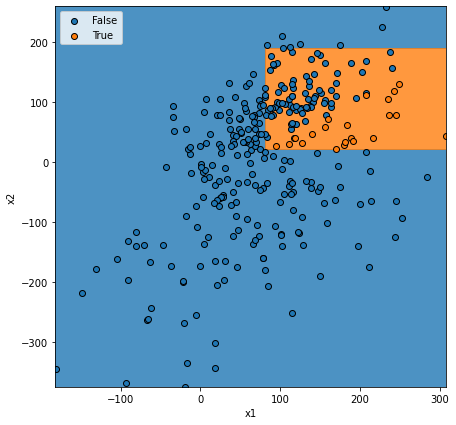

In [93]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

##### Level 2

In [94]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

1. 21.3 < x2 <= 145.5 and x1 > 194.5
2. 21.3 < x2 <= 121.3 and x1 > 81.1
3. 21.3 < x2 <= 188.4 and x1 > 111.3
              precision    recall  f1-score   support

       False       1.00      0.75      0.86       278
        True       0.24      1.00      0.39        22

    accuracy                           0.77       300
   macro avg       0.62      0.87      0.62       300
weighted avg       0.94      0.77      0.82       300



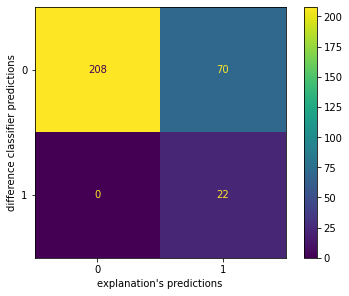

In [95]:
print_rules(rules)
node.root.evaluate_rules(*rules)

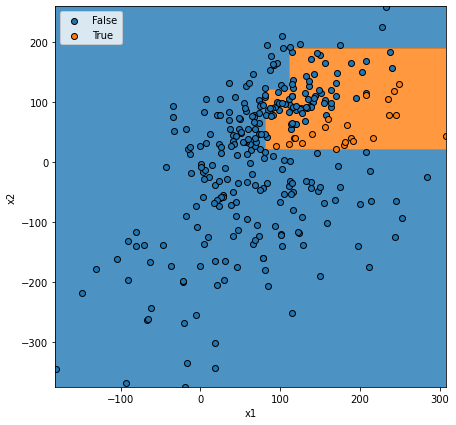

In [96]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

##### Level 3

In [97]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l3)

1. 21.3 < x2 <= 145.5 and x1 > 194.5
2. x1 > 81.1 and 21.3 < x2 <= 121.3
3. 21.3 < x2 <= 55.6 and x1 > 88.2
4. x1 > 111.3 and 21.3 < x2 <= 188.4
5. 21.3 < x2 <= 97.2 and x1 > 115.4
              precision    recall  f1-score   support

       False       1.00      0.75      0.86       278
        True       0.24      1.00      0.39        22

    accuracy                           0.77       300
   macro avg       0.62      0.87      0.62       300
weighted avg       0.94      0.77      0.82       300



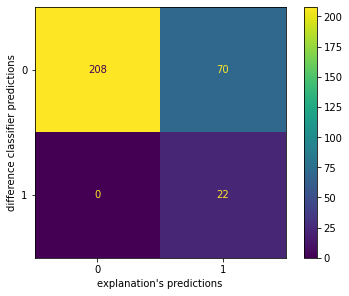

In [98]:
print_rules(rules)
node.root.evaluate_rules(*rules)

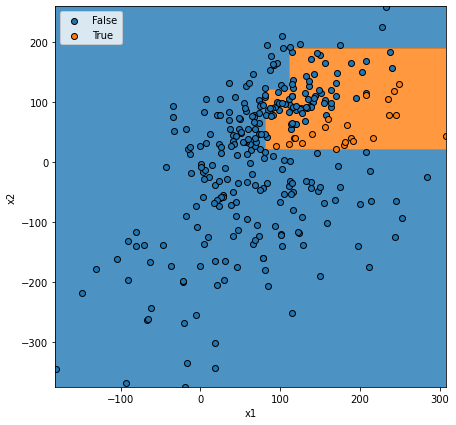

In [99]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

##### Level 4

In [100]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l4)

1. 21.3 < x2 <= 145.5 and x1 > 194.5
2. x1 > 81.1 and 21.3 < x2 <= 87.2
3. x1 > 89.5 and 21.3 < x2 <= 121.3
4. 21.3 < x2 <= 55.6 and x1 > 88.2
5. x1 > 111.3 and 21.3 < x2 <= 188.4
6. 21.3 < x2 <= 97.2 and x1 > 115.4
              precision    recall  f1-score   support

       False       1.00      0.75      0.86       278
        True       0.24      1.00      0.39        22

    accuracy                           0.77       300
   macro avg       0.62      0.88      0.62       300
weighted avg       0.94      0.77      0.82       300



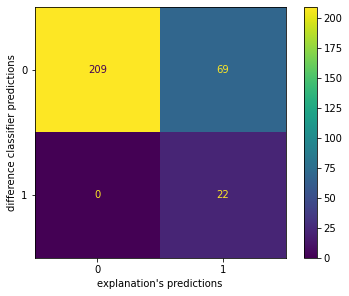

In [101]:
print_rules(rules)
node.root.evaluate_rules(*rules)

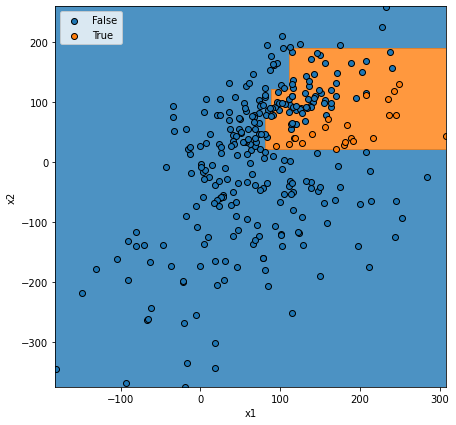

In [102]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

#### Counterfactual Fidelity Error

##### Global

In [103]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [104]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [105]:
rmse

x1    65.125526
x2    69.780800
dtype: float64

In [106]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [107]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Level 1

In [108]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [109]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [110]:
rmse

x1    36.086178
x2    67.928639
dtype: float64

In [111]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [112]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Level 2

In [113]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [114]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [115]:
rmse

x1    22.948232
x2    44.175757
dtype: float64

In [116]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [117]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Level 3

In [118]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l3)

In [119]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [120]:
rmse

x1    21.380875
x2    16.335530
dtype: float64

In [121]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [122]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Level 4

In [123]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l4)

In [124]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [125]:
rmse

x1    20.076762
x2    15.505549
dtype: float64

In [126]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [127]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

#### Complexity

##### Global

In [128]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [129]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 3 (3.0 per rule)


##### Level 1

In [130]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [131]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 6 (3.0 per rule)


##### Level 2

In [132]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [133]:
print_complexity(constraints)

Number of rules: 3
Number of constraints: 9 (3.0 per rule)


##### Level 3

In [134]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l3)

In [135]:
print_complexity(constraints)

Number of rules: 5
Number of constraints: 15 (3.0 per rule)


##### Level 4

In [136]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l4)

In [137]:
print_complexity(constraints)

Number of rules: 6
Number of constraints: 18 (3.0 per rule)


## Clustering of Class $(1, 0)$ SHAP Values

In [138]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 17.9 s, sys: 237 ms, total: 18.1 s
Wall time: 20.5 s


((1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 942.4325877789813)

In [139]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

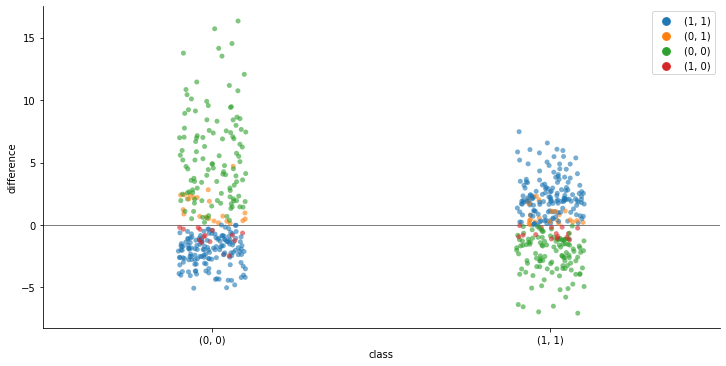

{'(0, 0)': '-2.47 to -0.2', '(1, 1)': '-1.2 to -0.05'}


In [140]:
node.plot_outcome_differences()

### Main Node (LR)

In [141]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LR,
 (1, 1)    126
 (0, 0)     49
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 111.58438112802642)

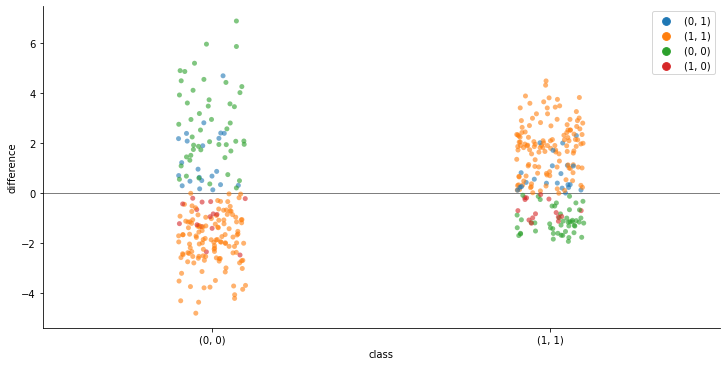

{'(0, 0)': '-2.47 to -0.2', '(1, 1)': '-1.2 to -0.05'}


In [142]:
node.plot_outcome_differences()

The instances classified $(1,0)$ are all below 78. Both $(1,0)$ and $(1,1)$ have a positively correlated linear relation between x1 and its SHAP value.

-43.73613231796008 <= x1 <= 62.966519499503526
[Upper CF: x1 == 77.9 --> {'(0, 0)': 15}]


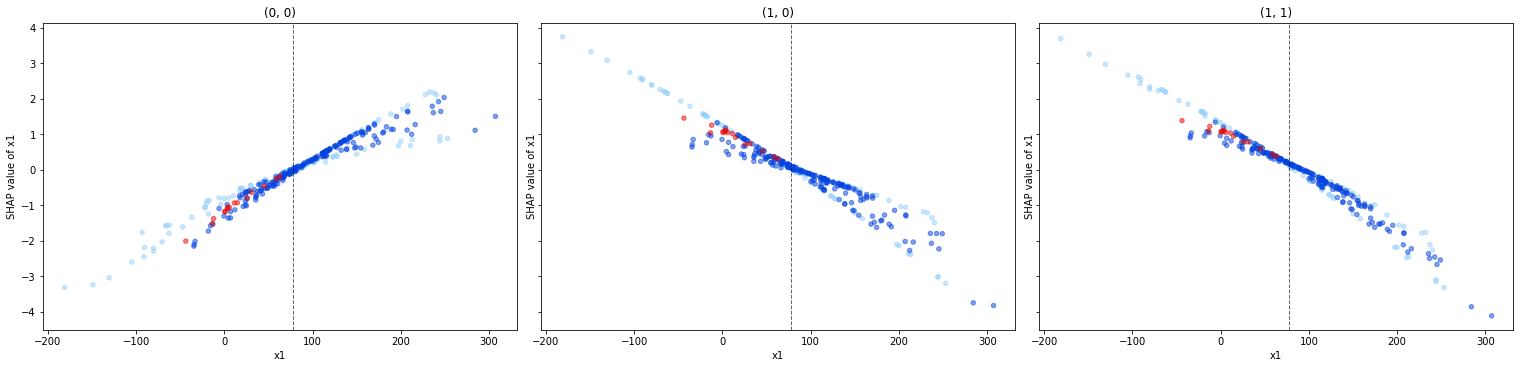

In [143]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

The dependence curve of $(0,0)$ is monotonically decreasing, while that of $(1,1)$ is monotonically increasing. The dependence curve of $(1,0)$ has a global high around 50, but instances in focus are to the left. Additionally we can see, that compared to the root, high x2 SHAP values were cut off from this cluster node.

-27.904182410204744 <= x2 <= 19.24556227701676
[Lower CF: x2 == -70.5 --> {'(0, 0)': 15},
 Upper CF: x2 == 21.4 --> {'(1, 1)': 15}]


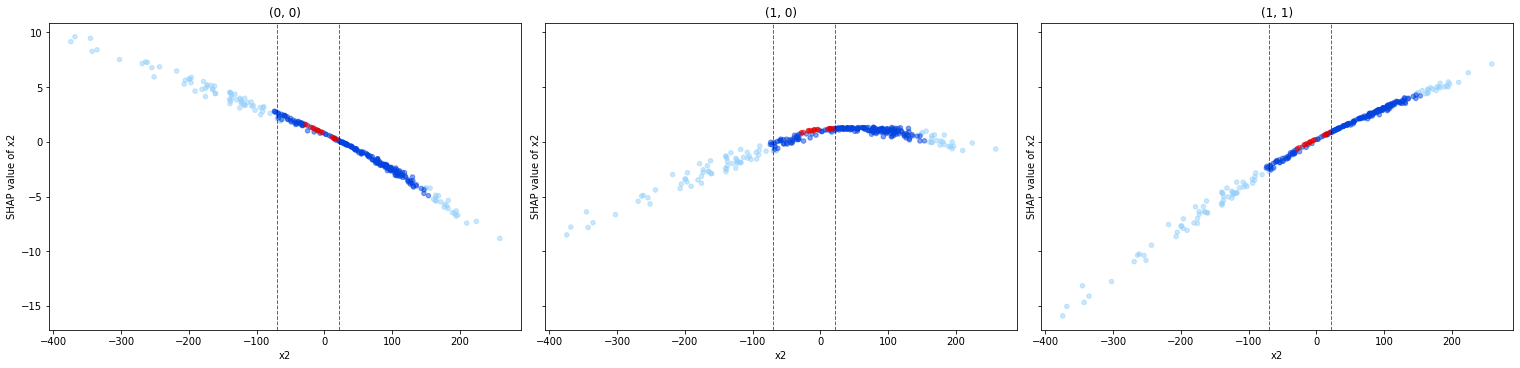

In [144]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

-70.5 < x2 <= 21.3 and x1 <= 77.8
              precision    recall  f1-score   support

       False       1.00      0.91      0.95       197
        True       0.45      1.00      0.62        15

    accuracy                           0.92       212
   macro avg       0.73      0.95      0.79       212
weighted avg       0.96      0.92      0.93       212



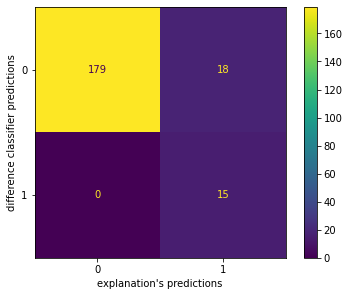

In [145]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [146]:
explanations_global = [(rule, constraint, instance_indices)]

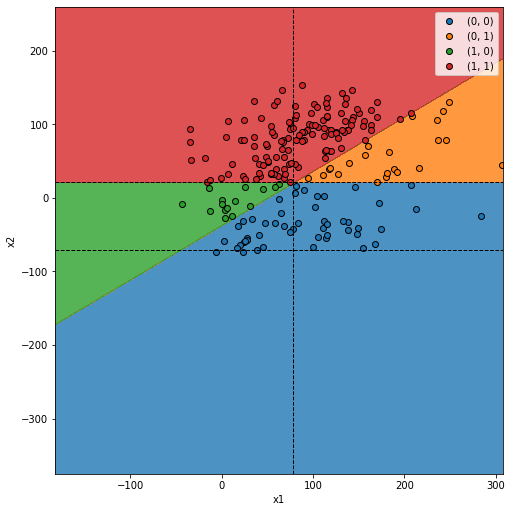

In [147]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 1 (LRRRRR)

The first child node contains 12 of the 15 instances currently in focus. According to the outcome differences plot, they are close to both equality classes.

In [148]:
node = node.root.get('LRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRRRR,
 (1, 0)    12
 (0, 0)     7
 (1, 1)     1
 dtype: int64,
 12.636562343857014)

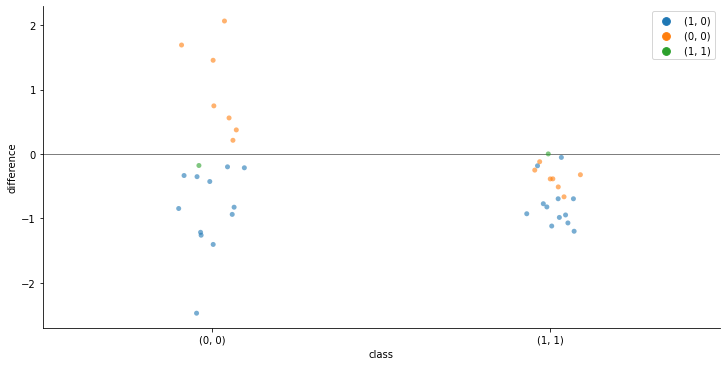

{'(0, 0)': '-2.47 to -0.2', '(1, 1)': '-1.2 to -0.05'}


In [149]:
node.plot_outcome_differences()

The local dependence curves aren't linear, but still monotonically increasing. The CF is equal to its parent. The local explanation gives us instances, that are very similar but have a different label. 7 of them classify $(0,0)$, which is in line with the counterfactual labels, and one of them classifies $(1,1)$. The reason for this instance might be a higher x2 value, as can be seen in the second plot.

-43.73613231796008 <= x1 <= 62.966519499503526
[Upper CF: x1 == 77.9 --> {'(0, 0)': 12}]


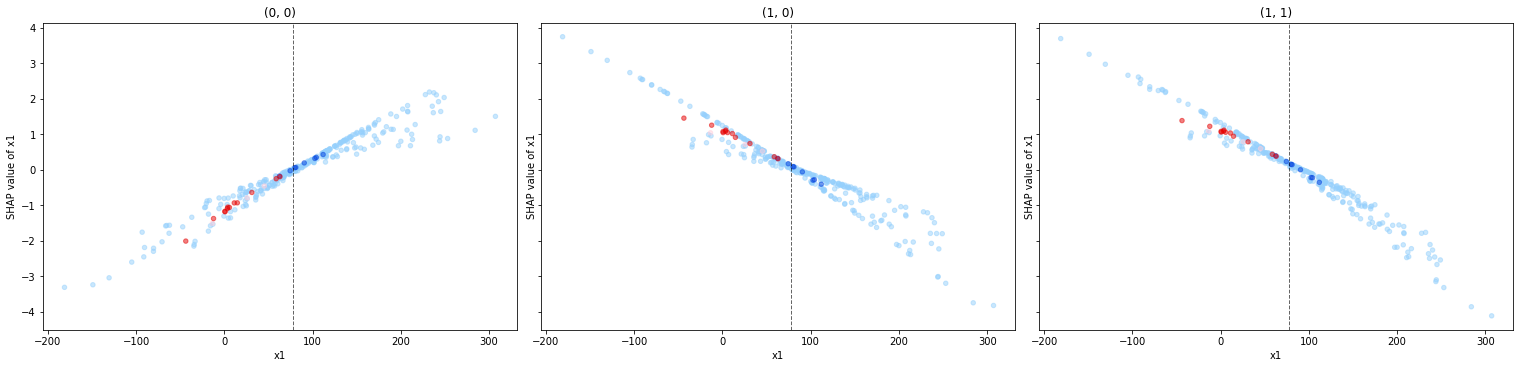

In [150]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

We can see, that now low x2 SHAP values were cut off by the clustering for this node too, leaving only a narrow range. This is because x2's SHAP values have a much larger range than x1's. We can also see, that the instances classified equally are most similar to those classified differently in terms of their x2 SHAP values.

-27.904182410204744 <= x2 <= 19.24556227701676
[Lower CF: x2 == -70.5 --> {'(0, 0)': 12},
 Upper CF: x2 == 21.4 --> {'(1, 1)': 12}]


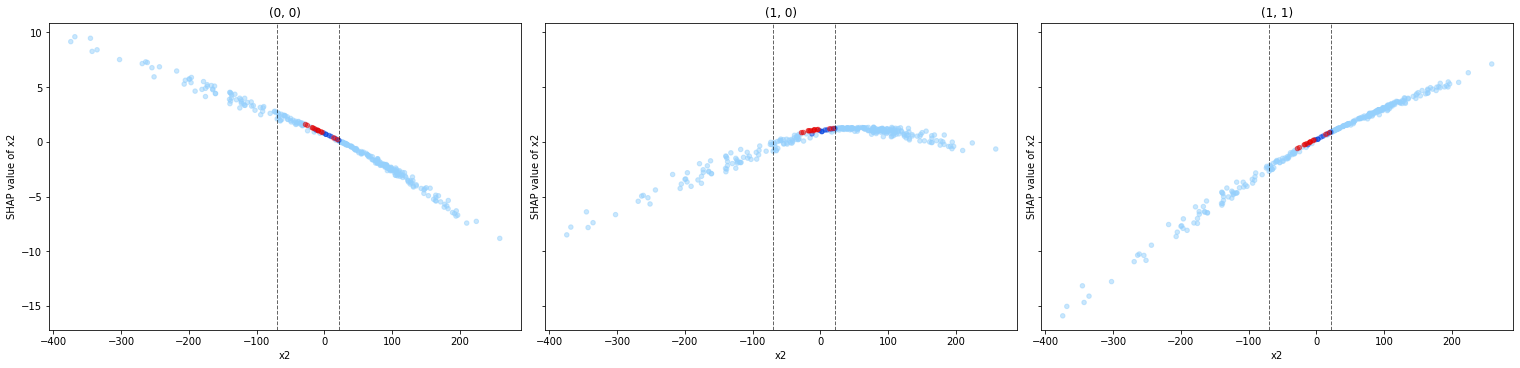

In [151]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

-70.5 < x2 <= 21.3 and x1 <= 77.8
              precision    recall  f1-score   support

       False       1.00      0.88      0.93         8
        True       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



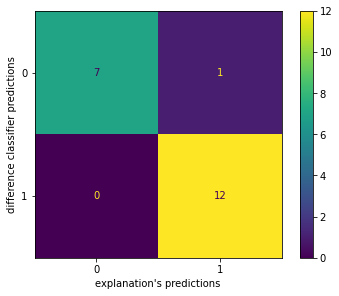

In [152]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [153]:
explanations_l1 = [(rule, constraint, instance_indices)]

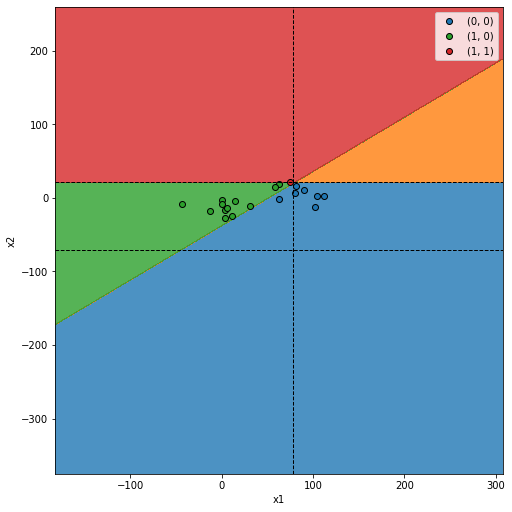

In [154]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

Compared to the sibling nodes' cluster distance, this nodes cluster distance is much higher (1.9 vs. 12.6). So I might get a more focused explanation in its child nodes.

### Node 1.1 (LRRRRRL)

Now this node contains only instances classified differently, this means that the data set lacks any instances classified equally that are more similar to these than those in the sibling node.

In [155]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRRRRL,
 (1, 0)    10
 dtype: int64,
 2.7673750149383602)

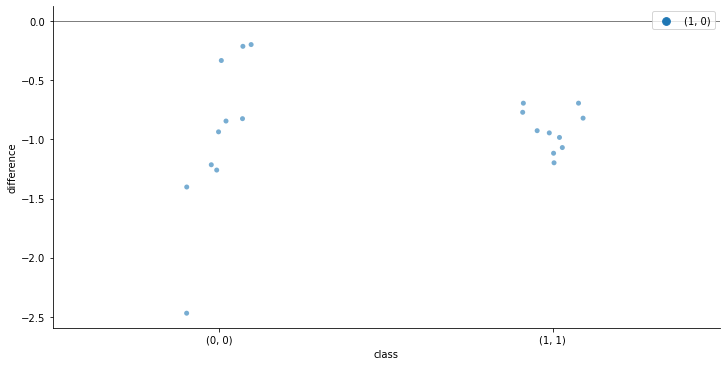

{'(0, 0)': '-2.47 to -0.2', '(1, 1)': '-1.2 to -0.69'}


In [156]:
node.plot_outcome_differences()

The upper CF is much lower than the parent's CF.

-43.73613231796008 <= x1 <= 31.13504268158801
[Upper CF: x1 == 47.1 --> {'(0, 0)': 10}]


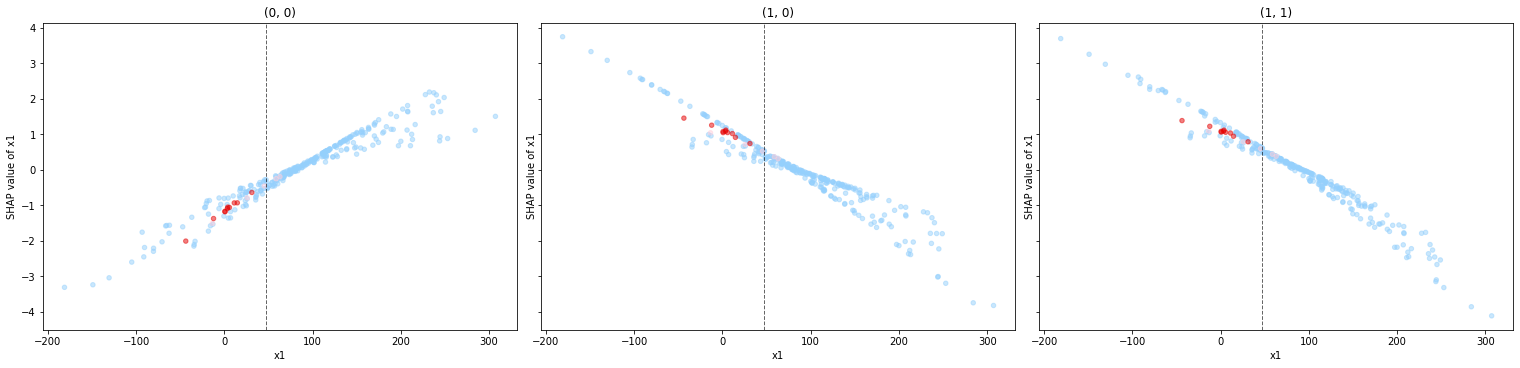

In [157]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

These CFs are equal to the parent's CFs.

-27.904182410204744 <= x2 <= -3.454652008977943
[Lower CF: x2 == -70.5 --> {'(0, 0)': 10},
 Upper CF: x2 == 21.4 --> {'(1, 1)': 10}]


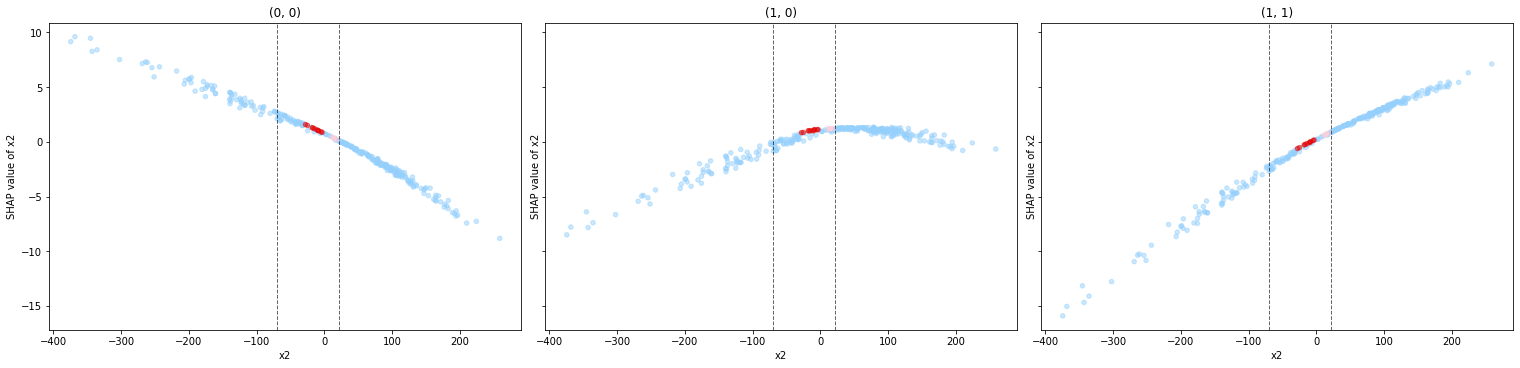

In [158]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

x1 <= 47.0 and -70.5 < x2 <= 21.3
              precision    recall  f1-score   support

        True       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



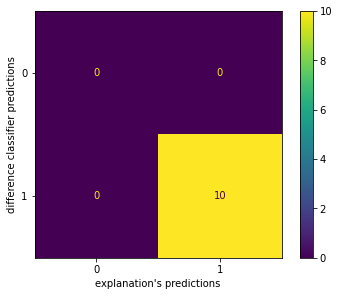

In [159]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [160]:
explanations_l2 = [(rule, constraint, instance_indices)]

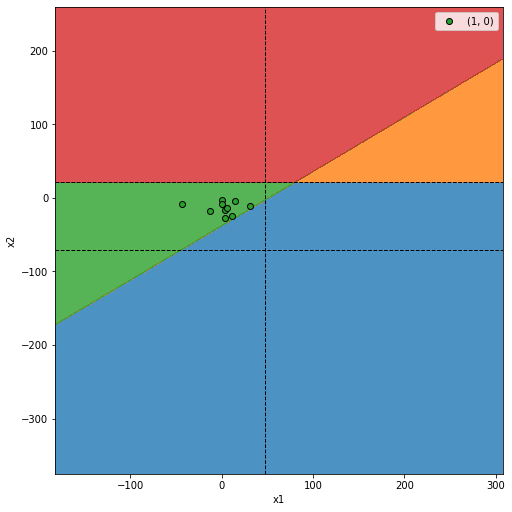

In [161]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 1.2 (LRRRRRRRRRL)

Descending the other child node, I arrive at a node where the two instances classified differently are contained exclusively. Going back up to its parent, I get two instances that are similar.

In [162]:
node = node.parent.get_right().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRRRRRRRRL,
 (1, 0)    2
 dtype: int64,
 0.06122566690646075)

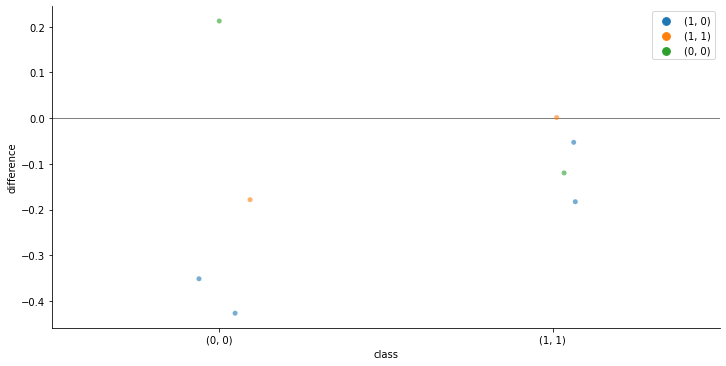

{'(0, 0)': '-0.43 to -0.35', '(1, 1)': '-0.18 to -0.05'}


((1, 0)    2
 (1, 1)    1
 (0, 0)    1
 dtype: int64,
 0.2753381122749902)

In [163]:
node = node.get_parent()
node.plot_outcome_differences()
node.class_counts, node.distance

The CF is the same as the parent's CF. The instance, that is just above the CF, is actually classified $(0,0)$ just like the CF instances themselves, which gives a strong support.

In [164]:
node.pred_classes[node.data[:, 0] > 78]

array(['(0, 0)'], dtype='<U6')

58.66508979458671 <= x1 <= 62.966519499503526
[Upper CF: x1 == 77.9 --> {'(0, 0)': 2}]


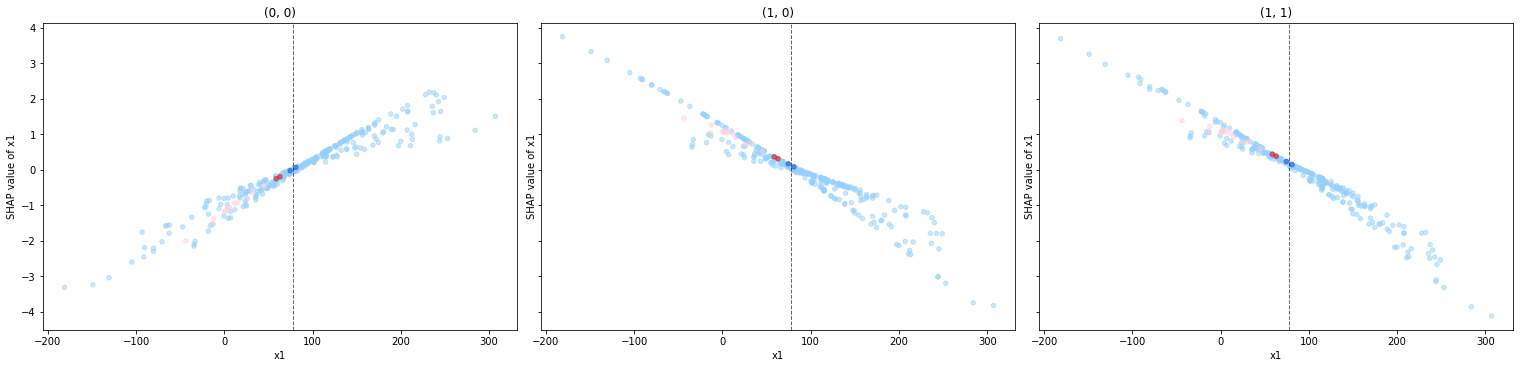

In [165]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

The upper CF is equal to, the lower CF is much higher than the parent's CF.

13.99257944405421 <= x2 <= 19.24556227701676
[Lower CF: x2 == 5.1 --> {'(0, 0)': 2}, Upper CF: x2 == 21.4 --> {'(1, 1)': 2}]


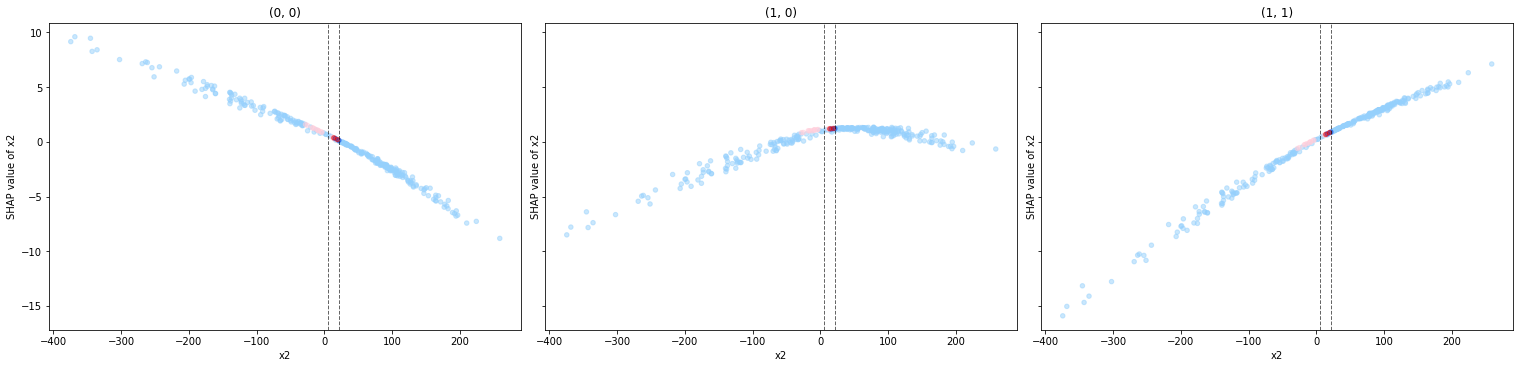

In [166]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

5.1 < x2 <= 21.3 and x1 <= 77.8
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         2
        True       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



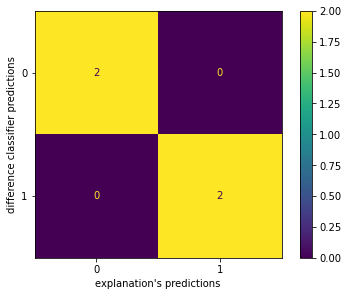

In [167]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [168]:
explanations_l2.append((rule, constraint, instance_indices))

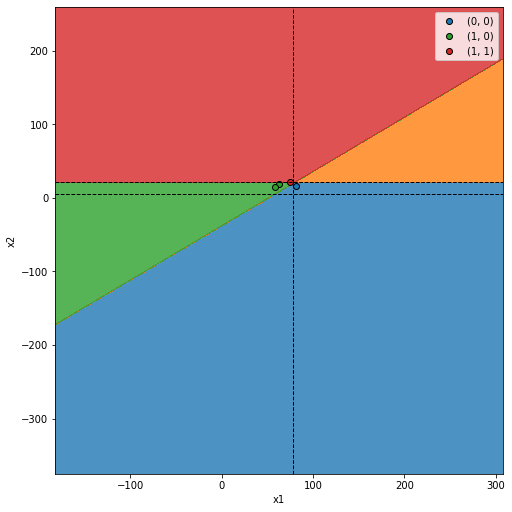

In [169]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Node 2 (LRRRRR)

In [170]:
node = node.root.get('LRL').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRLLRRLR,
 (1, 1)    6
 (1, 0)    3
 dtype: int64,
 1.9108791518242036)

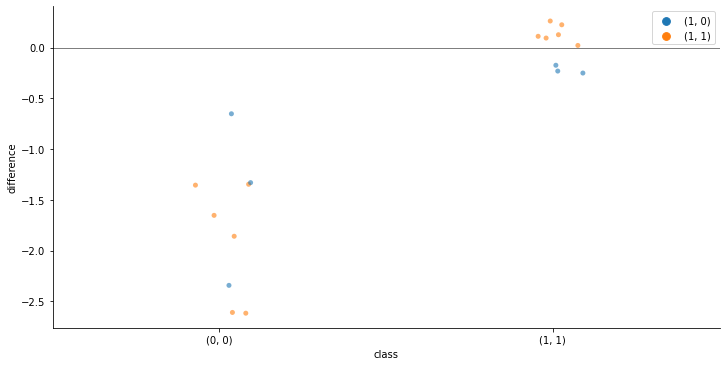

{'(0, 0)': '-2.34 to -0.65', '(1, 1)': '-0.25 to -0.17'}


In [171]:
node.plot_outcome_differences()

-13.608547578550045 <= x1 <= 45.255411008301124
[Upper CF: x1 == 72.3 --> {'(0, 0)': 3}]


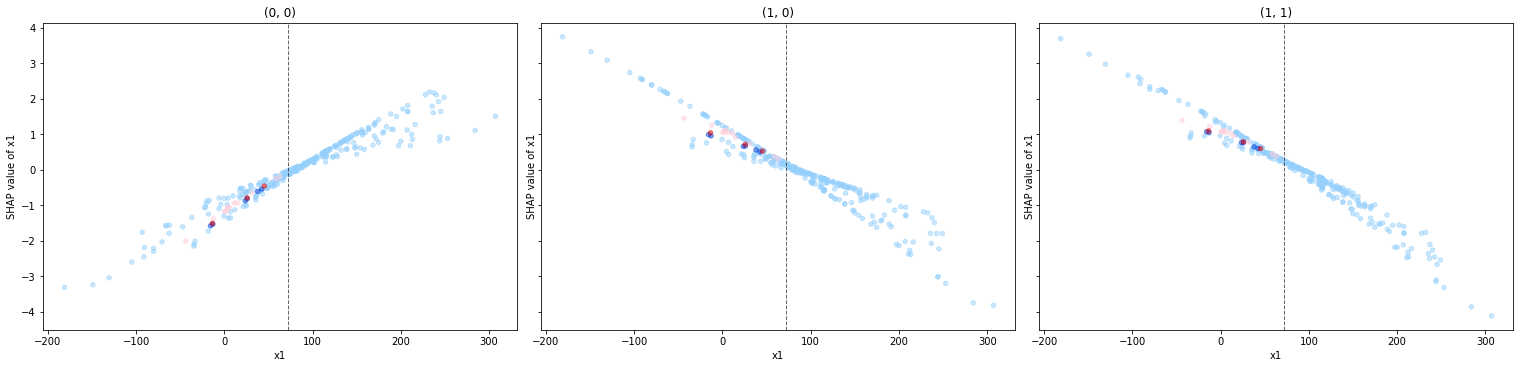

In [172]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

We can see, that now low x2 SHAP values were cut off by the clustering for this node too, leaving only a narrow range. This is because x2's SHAP values have a much larger range than x1's. We can also see, that the instances classified equally are most similar to those classified differently in terms of their x2 SHAP values.

11.625023695822245 <= x2 <= 15.157493874171458
[Lower CF: x2 == -48.2 --> {'(0, 0)': 3},
 Upper CF: x2 == 21.4 --> {'(1, 1)': 3}]


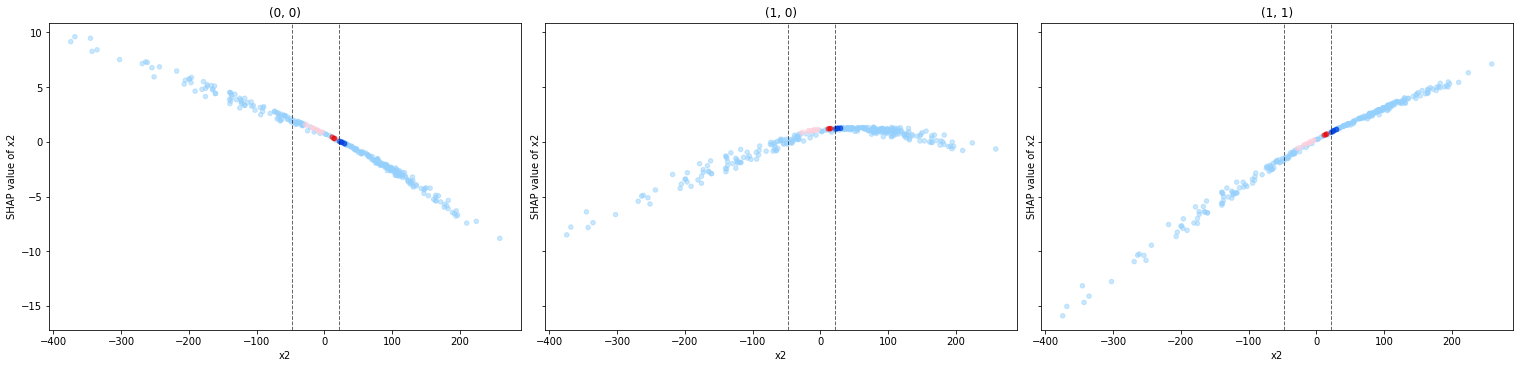

In [173]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

x1 <= 72.2 and -48.2 < x2 <= 21.3
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         6
        True       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



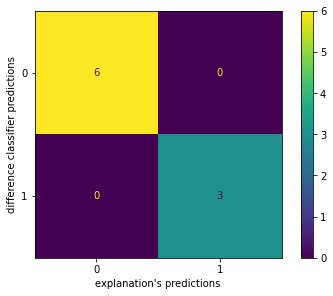

In [174]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [175]:
explanations_l1.append((rule, constraint, instance_indices))
explanations_l2.append((rule, constraint, instance_indices))

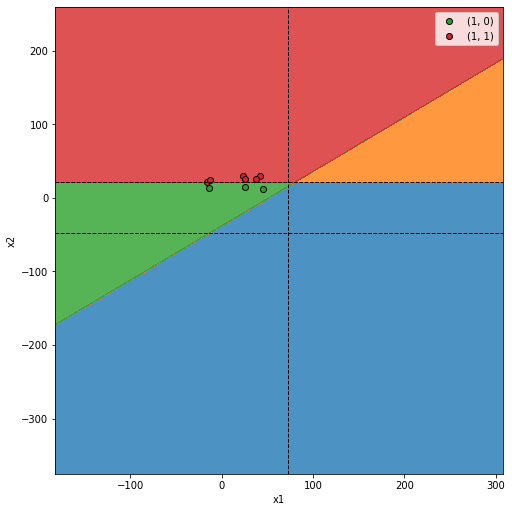

In [176]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Evaluation

#### Global Fidelity

##### Global

In [177]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

1. -70.5 < x2 <= 21.3 and x1 <= 77.8
              precision    recall  f1-score   support

       False       1.00      0.94      0.97       285
        True       0.45      1.00      0.62        15

    accuracy                           0.94       300
   macro avg       0.73      0.97      0.80       300
weighted avg       0.97      0.94      0.95       300



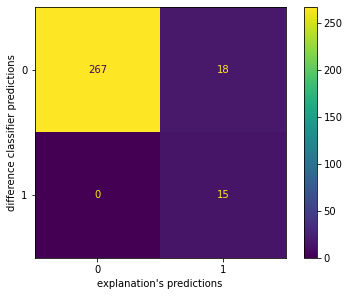

In [178]:
print_rules(rules)
node.root.evaluate_rules(*rules)

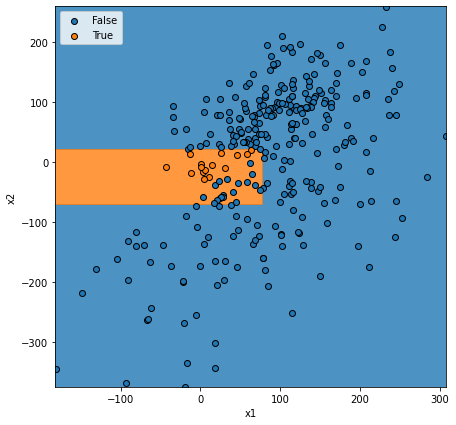

In [179]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

##### Level 1

In [180]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

1. -70.5 < x2 <= 21.3 and x1 <= 77.8
2. x1 <= 72.2 and -48.2 < x2 <= 21.3
              precision    recall  f1-score   support

       False       1.00      0.94      0.97       285
        True       0.45      1.00      0.62        15

    accuracy                           0.94       300
   macro avg       0.73      0.97      0.80       300
weighted avg       0.97      0.94      0.95       300



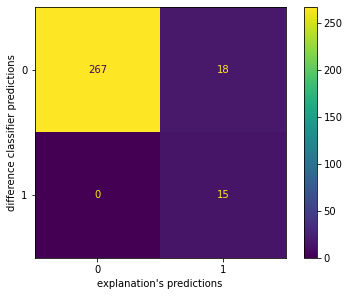

In [181]:
print_rules(rules)
node.root.evaluate_rules(*rules)

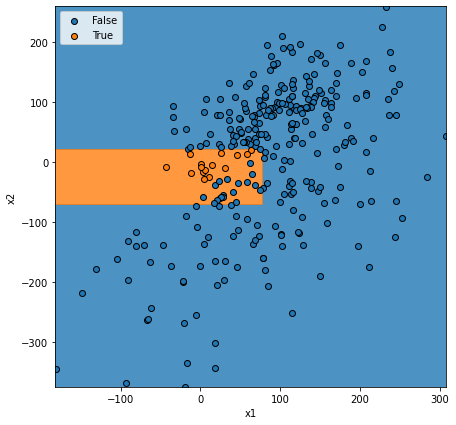

In [182]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

##### Level 2

In [183]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

1. x1 <= 47.0 and -70.5 < x2 <= 21.3
2. 5.1 < x2 <= 21.3 and x1 <= 77.8
3. x1 <= 72.2 and -48.2 < x2 <= 21.3
              precision    recall  f1-score   support

       False       1.00      0.94      0.97       285
        True       0.47      1.00      0.64        15

    accuracy                           0.94       300
   macro avg       0.73      0.97      0.80       300
weighted avg       0.97      0.94      0.95       300



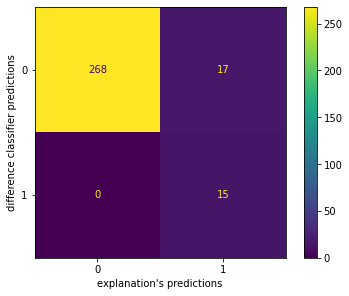

In [184]:
print_rules(rules)
node.root.evaluate_rules(*rules)

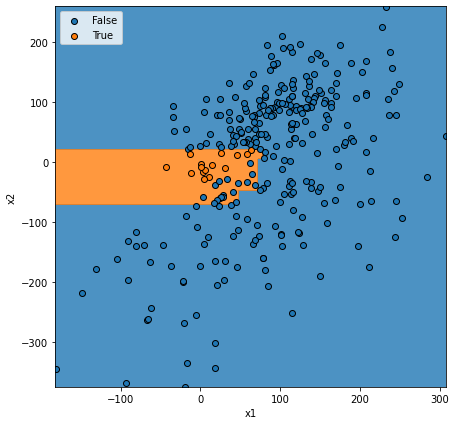

In [185]:
rclf = RuleClassifier(feature_names, rules)
fig, ax = plt.subplots(figsize=(7, 7))
plot_decision_boundary(node.root.data, node.root.highlight, feature_names=feature_names, predict=rclf.predict,
                       fig=fig, ax=ax)

#### Counterfactual Fidelity Error

##### Global

In [186]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [187]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [188]:
rmse

x1    37.880584
x2    32.851814
dtype: float64

In [189]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [190]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Level 1

In [191]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [192]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [193]:
rmse

x1    37.734441
x2    30.362444
dtype: float64

In [194]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [195]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Level 2

In [196]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [197]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [198]:
rmse

x1    14.546477
x2    22.917897
dtype: float64

In [199]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [200]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

#### Complexity

##### Global

In [201]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [202]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 3 (3.0 per rule)


##### Level 1

In [203]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [204]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 6 (3.0 per rule)


##### Level 2

In [205]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [206]:
print_complexity(constraints)

Number of rules: 3
Number of constraints: 9 (3.0 per rule)


# Summary

## Global Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
01/global | 22\% | 100\% | 36\%
01/level 1 | 22\% | 100\% | 36\%
01/level 2 | 24\% | 100\% | 39\%
01/level 3 | 24\% | 100\% | 39\%
01/level 4 | 24\% | 100\% | 39\%
10/global | 45\% | 100\% | 62\%
10/level 1 | 45\% | 100\% | 62\%
10/level 2 | 47\% | 100\% | 64\%

## Counterfactual Fidelity Error

Ruleset | RMSE | boundaries missed | unnecessary boundaries
 --- | --- | --- | ---
01/global | 68.3 | 0\% | 0\%
01/level 1 | 59.2 | 0\% | 0\%
01/level 2 | 38.4 | 0\% | 0\%
01/level 3 | 18.2 | 0\% | 0\%
01/level 4 | 17.2 | 0\% | 0\%
10/global | 34.6 | 0\% | 0\%
10/level 1 | 33.0 | 0\% | 0\%
10/level 2 | 20.5 | 0\% | 0\%

## Generation Time

approx. 50s

## Complexity

Ruleset | # Rules | # Terms
 --- | --- | ---
01/global | 1 | 3
01/level 1 | 2 | 6
01/level 2 | 3 | 9
01/level 3 | 5 | 15
01/level 4 | 6 | 18
10/global | 1 | 3
10/level 1 | 2 | 6
10/level 2 | 3 | 9